# Applied Master Project - Portfolio Insurance: OBPI vs CPPI

### MSc Financial Engineering

Ugo ESCATO  
Aurore CLEVENOT  
Ludovic VINCENTI

# Librairies used

In [2]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm, skew, kurtosis, jarque_bera
from arch import arch_model
from scipy import stats

# Data

In [3]:
btc_data = yf.download('BTC-USD')
btc_daily = btc_data['Close'][:'2025-02']
btc_weekly = btc_daily.resample('W').last()
btc_monthly = btc_daily.resample('ME').last()

# Extract the date range from the BTC data
start_date = btc_daily.index.min().strftime('%Y-%m-%d')
end_date = btc_daily.index.max().strftime('%Y-%m-%d')

# Download the US T-bill rate for the same period
t_bill_data = yf.download('^IRX', start=start_date, end=end_date)
t_bill_adj_close = t_bill_data['Close']

# Reindex T-bill data to match Bitcoin dates
t_bill_adj_close_reindexed = t_bill_adj_close.reindex(btc_daily.index)

# Interpolate missing T-bill rates
t_bill_daily = t_bill_adj_close_reindexed.interpolate(method='linear')
t_bill_weekly = t_bill_daily.resample('W').last()
t_bill_monthly = t_bill_daily.resample('ME').last()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
initial_portfolio_value = 100000  
multipliers = [1, 2, 3, 4, 5, 6]  # Array of multipliers
floor_fractions = [0.5, 0.6, 0.7, 0.8, 0.9, 1]  # Array of floor fractions (for CPPI), and strikes (for OBPI)

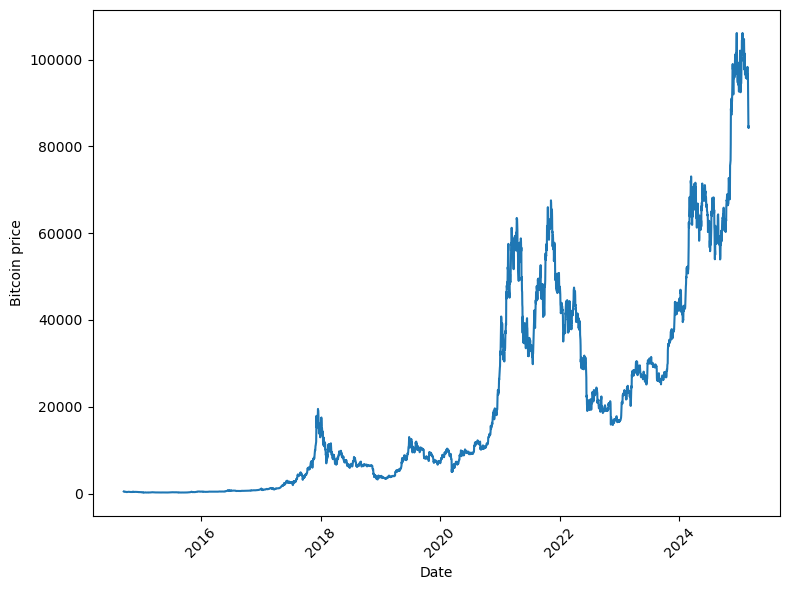

In [5]:
plt.figure(figsize=(8, 6))
plt.plot(btc_daily)
plt.xlabel('Date')
plt.ylabel('Bitcoin price')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

# Calibration

## Normality check

In [6]:
btc_returns = btc_daily.pct_change().dropna()

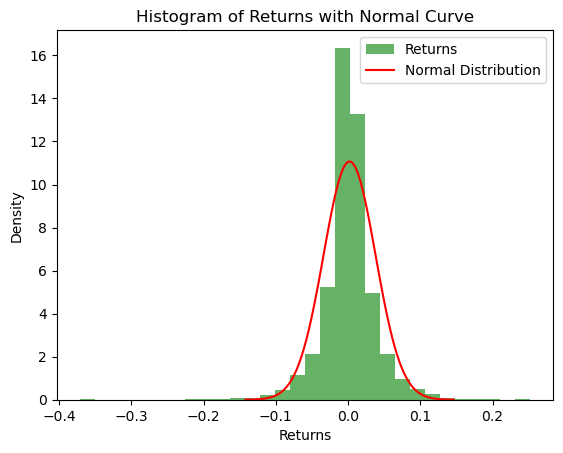

In [7]:
plt.hist(btc_returns, bins=30, density=True, alpha=0.6, color='g', label="Returns")

# Overlay normal distribution
mu, std = np.mean(btc_returns), np.std(btc_returns, axis=0)
x = np.linspace(mu - 4*std, mu + 4*std, 100)
plt.plot(x, stats.norm.pdf(x, mu, std), 'r', label="Normal Distribution")

plt.title("Histogram of Returns with Normal Curve")
plt.xlabel("Returns")
plt.ylabel("Density")
plt.legend()
plt.show()

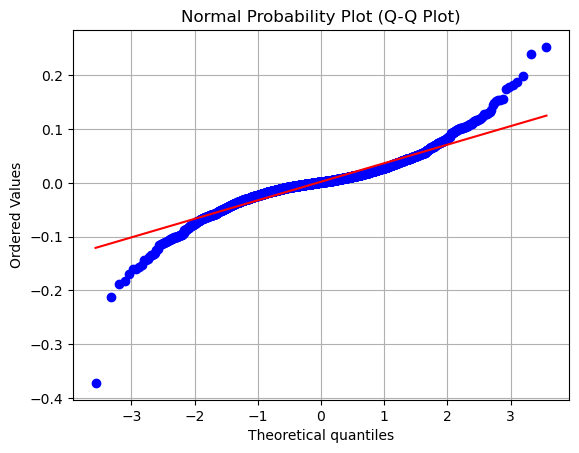

In [8]:
stats.probplot(btc_returns.values.flatten(), dist='norm', plot=plt)
plt.title('Normal Probability Plot (Q-Q Plot)')
plt.grid(True)
plt.show()

In [9]:
skewness = skew(btc_returns)
kurt = kurtosis(btc_returns)
print(f"Skewness: {skewness}")
print(f"Kurtosis: {kurt}")

if abs(skewness) < 0.5 and abs(kurt - 3) < 1:
    print("Returns are approximately normally distributed.")
else:
    print("Returns are NOT normally distributed.")

Skewness: [-0.11085545]
Kurtosis: [7.60254767]
Returns are NOT normally distributed.


In [10]:
# Jarque-Bera test
stat, p = jarque_bera(btc_returns)
print(f"Jarque-Bera Test: Statistic={stat}, p-value={p}")

alpha = 0.05
if p > alpha:
    print("Fail to reject the null hypothesis: Returns are normally distributed.")
else:
    print("Reject the null hypothesis: Returns are NOT normally distributed.")

Jarque-Bera Test: Statistic=9200.224341408677, p-value=0.0
Reject the null hypothesis: Returns are NOT normally distributed.


As expected, Bitcoin returns do not follow a normal distribution. While the skewness is modest, the returns exhibit heavy tails (high kurtosis), indicating that a normal distribution would underestimate extreme upward and downward movements. For now, we will continue using a GBM for our simulations, incorporating EGARCH to model volatility and capture fat tails. Later, we will address this limitation by adopting more realistic distributions.

## Simulations using GBM

In [11]:
def simulate_gbm(initial_price, mu, sigma, time_horizon, steps_per_year, num_simulations):
    """
    Simulates asset price evolution using Geometric Brownian Motion (GBM) with time-varying volatility.

    Parameters:
        initial_price (float): Current asset price.
        mu (float): Drift (mean return).
        sigma (float or np.ndarray): Volatility (constant float or array of shape (total_steps,)).
        time_horizon (float): Time horizon in years.
        steps_per_year (int): Number of time steps per year (e.g., 252 for daily steps).
        num_simulations (int): Number of Monte Carlo simulations.

    Returns:
        np.ndarray: Simulated price paths of shape (steps + 1, simulations).
    """
    dt = 1 / steps_per_year
    total_steps = int(time_horizon * steps_per_year)  
    
    # Ensure sigma is an array of shape (total_steps,)
    if np.isscalar(sigma):
        sigma = np.full(total_steps, sigma)  
    elif len(sigma) != total_steps:
        raise ValueError("sigma must be a scalar or an array of length equal to total_steps.")
    
    # Initialize price paths
    price_paths = np.zeros((total_steps + 1, num_simulations))
    price_paths[0] = initial_price  # Set initial price
    
    # Simulate GBM paths with time-varying sigma
    for t in range(1, total_steps + 1):
        z = np.random.standard_normal(num_simulations)  # Random shocks
        
        # GBM formula with time-dependent sigma 
        price_paths[t] = price_paths[t - 1] * np.exp(
            (mu - 0.5 * sigma[t - 1]**2) * dt + sigma[t - 1] * np.sqrt(dt) * z
        )
    
    return price_paths

### Historical volatility

In [12]:
def calculate_mean_and_volatility(returns):
    simple_returns = returns.pct_change().dropna()
    log_returns = np.log(returns / returns.shift(1)).dropna()

    mean = simple_returns.mean() * 365
    volatility = log_returns.std() * np.sqrt(365)
    
    return mean, volatility

In [13]:
historical_mean, historical_volatility = calculate_mean_and_volatility(btc_daily)
historical_sharpe_ratio = historical_mean/historical_volatility

print(f"Mean (Simple Returns): {historical_mean}")
print(f"Volatility (Log Returns): {historical_volatility}")
print(f'Sharpe Ratio: {historical_sharpe_ratio}')

Mean (Simple Returns): Ticker
BTC-USD    0.737998
dtype: float64
Volatility (Log Returns): Ticker
BTC-USD    0.693099
dtype: float64
Sharpe Ratio: Ticker
BTC-USD    1.06478
dtype: float64


In [14]:
initial_price = btc_daily.iloc[-1]  
mu = historical_mean.iloc[0]  # Drift (annualized mean return) 
sigma = historical_volatility.iloc[0]  # Volatility (annualized standard deviation)
time_horizon = 1  # in year
steps_per_year = 365  # 365 for daily, 52 for weekly
num_simulations = 1000  

price_paths = simulate_gbm(initial_price, mu, sigma, time_horizon, steps_per_year, num_simulations)

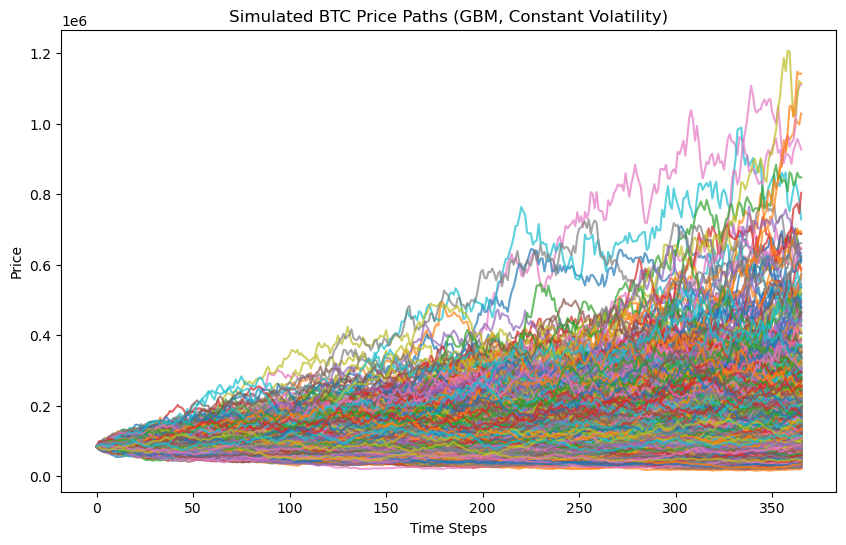

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(price_paths, alpha=0.7)
plt.title("Simulated BTC Price Paths (GBM, Constant Volatility)")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.show()

#### CPPI

In [16]:
def cppi_strategy(risky_asset, riskless_rate, multipliers, floor_fractions, initial_portfolio_value):
    """
    Implements the CPPI (Constant Proportion Portfolio Insurance) strategy for multiple combinations
    of multiplier and floor_fraction values.

    Parameters:
        risky_asset (ndarray): Prices of the risky asset (e.g., BTC), shape (n_steps, n_simulations).
        riskless_rate (float): The constant annual risk-free rate (e.g., 0.02 for 2%).
        multipliers (array-like): Array of multipliers for the cushion.
        floor_fractions (array-like): Array of floor fractions of the initial portfolio value.
        initial_portfolio_value (float): Initial value of the portfolio.

    Returns:
        dict: A dictionary containing results for each (multiplier, floor_fraction) combination.
    """

    n_steps, n_simulations = risky_asset.shape
    riskless_return = (1 + riskless_rate) ** (1 / 365) - 1

    results = {}

    for multiplier in multipliers:
        for floor_fraction in floor_fractions:
            # Initialize arrays
            basket_values = np.zeros((n_steps, n_simulations))
            risky_weights = np.zeros((n_steps, n_simulations))
            riskless_weights = np.zeros((n_steps, n_simulations))

            # Initial conditions
            basket_values[0] = initial_portfolio_value
            floor = initial_portfolio_value * floor_fraction

            # Compute the initial cushion
            initial_cushion = np.maximum(basket_values[0] - floor, 0) / basket_values[0]
            
            risky_weights[0] = np.maximum(multiplier * initial_cushion, 0)
            riskless_weights[0] = 1 - risky_weights[0]

            # CPPI dynamics for each time step
            for t in range(1, n_steps):
                # Compute risky returns
                risky_returns = (risky_asset[t] - risky_asset[t - 1]) / risky_asset[t - 1]

                # Portfolio return: combine risky and riskless returns
                port_returns = (risky_weights[t-1] * risky_returns + 
                               riskless_weights[t-1] * riskless_return)
                
                # Update portfolio value
                basket_values[t] = basket_values[t-1] * (1 + port_returns)
                
                # Update weights
                cushion = np.maximum(basket_values[t] - floor, 0) / basket_values[t]
                risky_weights[t] = np.maximum(multiplier * cushion, 0)
                riskless_weights[t] = 1 - risky_weights[t]

            # Store the results for the current multiplier and floor_fraction
            results[(multiplier, floor_fraction)] = {
                'Basket Values': basket_values,
                'Risky Weights': risky_weights,
                'Riskless Weights': riskless_weights
            }

    return results

In [17]:
cppi_results = cppi_strategy(price_paths, 0.04, multipliers, floor_fractions, initial_portfolio_value)

In [18]:
multiplier = 3
floor_frac = 0.8
key = (multiplier, floor_frac)

terminal_prices = price_paths[-1]  # Last row of price simulations
terminal_cppi = cppi_results[key]['Basket Values'][-1]  # Last row of CPPI basket values

#### OBPI

In [19]:
def obpi_strategy(risky_asset, riskless_rate, floor_fractions, initial_portfolio_value, time_to_maturity, sigma):
    """
    Implements the OBPI (Option-Based Portfolio Insurance) strategy for multiple floor fractions.

    Parameters:
        risky_asset (ndarray): Simulated risky asset prices, shape (n_steps, n_simulations).
        riskless_rate (float): Annualized risk-free rate (e.g., 0.02 for 2%).
        floor_fractions (list): List of floor fractions to test.
        initial_portfolio_value (float): Initial value of the portfolio.
        time_to_maturity (float): Time to maturity in years.
        sigma (float or ndarray): Volatility of the risky asset (annualized), 
                                  either a float (constant) or ndarray (n_steps, n_simulations).

    Returns:
        dict: Dictionary containing results for each floor fraction.
    """
    n_steps, n_simulations = risky_asset.shape
    steps_per_year = 365  # adjust
    riskless_return = (1 + riskless_rate) ** (1 / steps_per_year) - 1
    dt = 1 / steps_per_year  
    results = {}

    def black_scholes_put(S, K, T, r, sigma):
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        put_delta = -norm.cdf(-d1)
        return put_price, put_delta

    # Ensure sigma is an array of correct shape (n_steps, n_simulations)
    if np.isscalar(sigma):
        sigma = np.full((n_steps, n_simulations), sigma)

    if sigma.shape != (n_steps, n_simulations):
        raise ValueError("sigma must be either a scalar or have shape (n_steps, n_simulations)")

    for floor_fraction in floor_fractions:
        # Initialize arrays
        basket_values = np.zeros((n_steps, n_simulations))
        risky_weights = np.zeros((n_steps, n_simulations))
        riskless_weights = np.zeros((n_steps, n_simulations))
        put_prices = np.zeros((n_steps, n_simulations))
        put_deltas = np.zeros((n_steps, n_simulations))

        # Initial conditions
        floor = initial_portfolio_value * floor_fraction

        # Compute initial put price and delta for all simulations
        initial_put_price, initial_put_delta = black_scholes_put(
            risky_asset[0], floor, time_to_maturity, riskless_rate, sigma[0]
        )

        # Compute initial weights
        risky_w = ((1 + initial_put_delta) * risky_asset[0]) / (risky_asset[0] + initial_put_price)
        risky_w = np.maximum(0, np.minimum(1, risky_w))
        riskless_w = 1 - risky_w

        # Set initial values
        basket_values[0, :] = initial_portfolio_value
        risky_weights[0, :] = risky_w
        riskless_weights[0, :] = riskless_w
        put_prices[0, :] = initial_put_price
        put_deltas[0, :] = initial_put_delta

        # Loop over time steps
        for i in range(1, n_steps):
            remaining_ttm = time_to_maturity - i * dt  

            # Compute returns
            risky_return = (risky_asset[i] - risky_asset[i - 1]) / risky_asset[i - 1]

            # Update portfolio value
            portfolio_return = (risky_weights[i - 1] * risky_return +
                                riskless_weights[i - 1] * riskless_return)
            basket_values[i] = basket_values[i - 1] * (1 + portfolio_return)

            # Compute new put option price and delta 
            put_price, put_delta = black_scholes_put(
                risky_asset[i], floor, remaining_ttm, riskless_rate, sigma[i]
            )

            # Update weights
            risky_w = ((1 + put_delta) * risky_asset[i]) / (risky_asset[i] + put_price)
            risky_w = np.maximum(0, np.minimum(1, risky_w))
            riskless_w = 1 - risky_w

            # Store values
            risky_weights[i] = risky_w
            riskless_weights[i] = riskless_w
            put_prices[i] = put_price
            put_deltas[i] = put_delta

        # Store results
        results[floor_fraction] = {
            "Basket Values": basket_values,
            "Risky Weights": risky_weights,
            "Riskless Weights": riskless_weights,
            "Put Price": put_prices,
            "Put Delta": put_deltas,
        }

    return results

In [20]:
time_to_maturity = len(price_paths)/365  # adjust (52 for weekly, 365 for daily)

obpi_results = obpi_strategy(price_paths, 0.04, floor_fractions, initial_portfolio_value, time_to_maturity, historical_volatility.iloc[0])

In [21]:
floor_frac_obpi = 1
key = (floor_frac_obpi)

terminal_prices = price_paths[-1]  # Last row of price simulations
terminal_obpi = obpi_results[key]['Basket Values'][-1]  # Last row of OBPI basket values

#### Buy and Hold

In [22]:
def buy_and_hold_strategy(price_paths, riskless_rate, initial_portfolio_value, time_to_maturity):
    """
    Implements a buy-and-hold strategy with a risky asset and a riskless asset.

    Parameters:
        price_paths (ndarray): Simulated risky asset prices, shape (n_steps, n_simulations).
        riskless_rate (float): Annualized risk-free rate (e.g., 0.02 for 2%).
        initial_portfolio_value (float): Initial value of the portfolio.
        time_to_maturity (float): Time to maturity in years.

    Returns:
        dict: Dictionary containing portfolio values, risky asset values, and riskless asset values.
    """
    n_steps, n_simulations = price_paths.shape
    dt = time_to_maturity / (n_steps - 1)  # Time step in years

    # Initialize arrays
    portfolio_values = np.zeros((n_steps, n_simulations))
    risky_values = np.zeros((n_steps, n_simulations))
    riskless_values = np.zeros((n_steps, n_simulations))

    # Initial allocation
    risky_weight = 0.6
    riskless_weight = 0.4

    # Initial values
    risky_values[0, :] = initial_portfolio_value * risky_weight
    riskless_values[0, :] = initial_portfolio_value * riskless_weight
    portfolio_values[0, :] = initial_portfolio_value

    # Compute riskless asset growth over time
    time_steps = np.arange(n_steps) * dt  
    riskless_growth = (1 + riskless_rate) ** time_steps  # Cumulative growth of riskless asset
    riskless_asset_values = initial_portfolio_value * riskless_weight * riskless_growth[:, np.newaxis]

    # Compute risky asset growth 
    risky_initial_price = price_paths[0]  
    risky_asset_values = risky_values[0, :] * (price_paths / risky_initial_price)

    # Portfolio value is the sum of risky and riskless components
    portfolio_values = risky_asset_values + riskless_asset_values

    # Store results
    results = {
        "Basket Values": portfolio_values,
        "Risky Values": risky_asset_values,
        "Riskless Values": riskless_asset_values,
    }

    return results

In [23]:
bnh_results = buy_and_hold_strategy(
    price_paths=price_paths,
    riskless_rate=0.04,
    initial_portfolio_value=100000,
    time_to_maturity=len(price_paths)/365
)

In [24]:
terminal_prices = price_paths[-1]  # Last row of price simulations
terminal_bnh = bnh_results['Basket Values'][-1]  # Last row of B&H basket values

##### Analysis

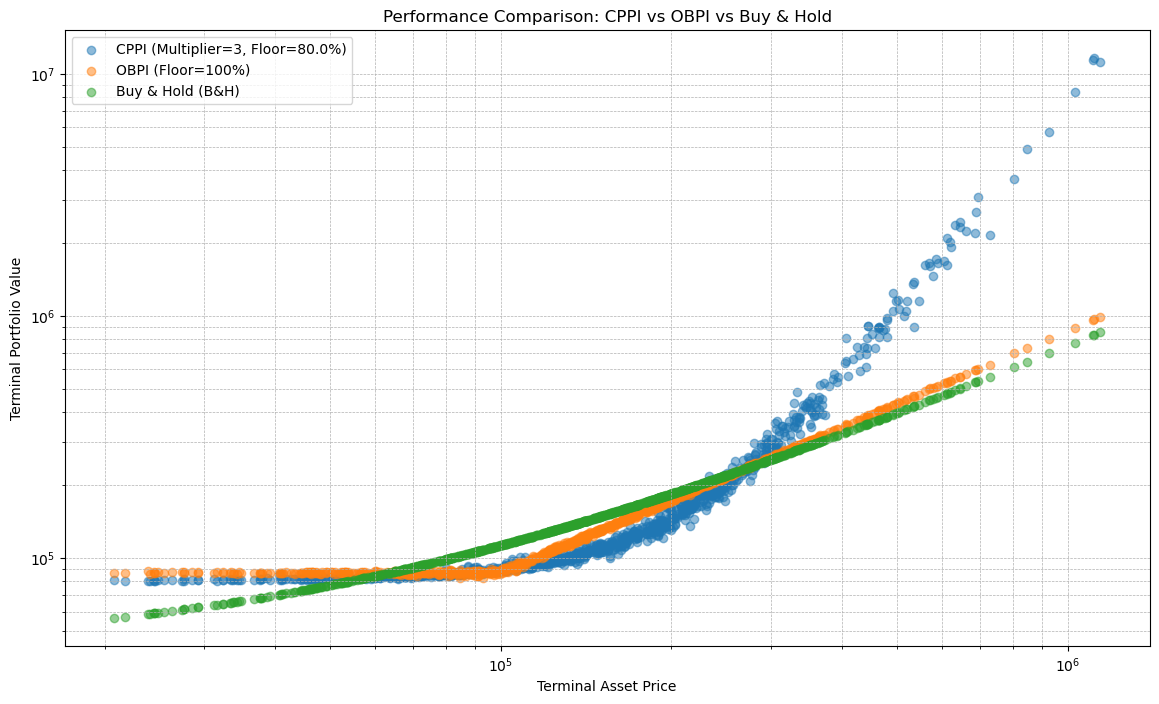

In [25]:
plt.figure(figsize=(14, 8))

# CPPI Outcomes 
plt.scatter(terminal_prices, terminal_cppi, 
            alpha=0.5, 
            label=f'CPPI (Multiplier={multiplier}, Floor={floor_frac*100}%)')

# OBPI Outcomes 
plt.scatter(terminal_prices, terminal_obpi, 
            alpha=0.5, 
            label=f'OBPI (Floor={floor_frac_obpi*100}%)')

# Buy & Hold Outcomes
plt.scatter(terminal_prices, terminal_bnh, 
            alpha=0.5, 
            label='Buy & Hold (B&H)')

plt.title('Performance Comparison: CPPI vs OBPI vs Buy & Hold')
plt.xlabel('Terminal Asset Price')
plt.xscale('log')  # Use log scale for better visualization
plt.ylabel('Terminal Portfolio Value')
plt.yscale('log')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [26]:
def performance(portfolio_values, benchmark_prices):
    """
    Calculate performance metrics for a portfolio across multiple simulations with benchmark.

    Parameters:
    - portfolio_values (np.ndarray): Shape (n_steps, n_simulations), portfolio values over time.
    - benchmark_prices (np.ndarray): Shape (n_steps, n_simulations), benchmark values over time.

    Returns:
    - dict: Averaged performance metrics across simulations:
        - annualized return, volatility, Sharpe ratio, Sortino ratio,
          VaR 5%, Expected Shortfall (CVaR), skewness, kurtosis, max drawdown,
          and information ratio.
    """
    # Ensure inputs are NumPy arrays
    portfolio_values = np.asarray(portfolio_values)
    benchmark_prices = np.asarray(benchmark_prices)

    # Validate dimensions
    if portfolio_values.shape != benchmark_prices.shape:
        raise ValueError("portfolio_values and benchmark_prices must have the same shape.")
        
    if portfolio_values.shape[0] < 2:
        raise ValueError("At least two time steps are required for performance calculation.")
        
    # Dimensions
    n_steps, n_simulations = portfolio_values.shape

    total_return = (portfolio_values[-1, :] / portfolio_values[0, :]) - 1

    def safe_annualized_return(total_return, n_steps, periods_per_year=365): # Debug
        # Check for invalid inputs
        if n_steps <= 0:
            raise ValueError("n_steps must be greater than zero for annualization.")
            
        if np.any(np.isnan(total_return)) or np.any(np.isinf(total_return)):
            raise ValueError("total_return contains NaN or Inf values.")
            
        # Ensure valid range for total_return
        total_return = np.clip(total_return, -0.999, None)  # Avoid (1 + total_return) < 0

        # Calculate annualized return safely
        try:
            annualized_return = (1 + total_return) ** (periods_per_year / n_steps) - 1
        except Exception as e:
            raise RuntimeError(f"Error computing annualized return: {e}")

        return annualized_return
    
    annualized_return = safe_annualized_return(total_return, n_steps)

    # Daily returns (or periodic returns)
    portfolio_daily_returns = np.diff(portfolio_values, axis=0) / portfolio_values[:-1, :]
    benchmark_daily_returns = np.diff(benchmark_prices, axis=0) / benchmark_prices[:-1, :]

    # Annualized volatility
    annualized_volatility = np.std(portfolio_daily_returns, axis=0) * np.sqrt(365)

    # Sharpe ratio (assuming risk-free rate = 0)
    sharpe_ratio = annualized_return / annualized_volatility

    # Sortino ratio 
    downside_returns = np.where(portfolio_daily_returns < 0, portfolio_daily_returns, 0)
    downside_risk = np.std(downside_returns, axis=0) * np.sqrt(365)
    sortino_ratio = annualized_return / downside_risk

    # Value at Risk (VaR 5%) and Conditional VaR (Expected Shortfall)
    var_5 = np.percentile(portfolio_daily_returns, 5, axis=0)
    es_5 = np.array([np.mean(portfolio_daily_returns[:, i][portfolio_daily_returns[:, i] <= var_5[i]]) for i in range(n_simulations)])

    # Skewness and kurtosis 
    skewness = np.mean(((portfolio_daily_returns - np.mean(portfolio_daily_returns, axis=0))**3), axis=0) / np.std(portfolio_daily_returns, axis=0)**3
    kurtosis = np.mean(((portfolio_daily_returns - np.mean(portfolio_daily_returns, axis=0))**4), axis=0) / np.std(portfolio_daily_returns, axis=0)**4

    # Maximum drawdown calculation (in percentage)
    cumulative_max = np.maximum.accumulate(portfolio_values, axis=0)
    drawdown = (portfolio_values - cumulative_max) / cumulative_max
    max_drawdown = np.min(drawdown, axis=0) 

    # Information ratio (excess return relative to the benchmark)
    excess_returns = portfolio_daily_returns - benchmark_daily_returns
    information_ratio = np.divide(np.mean(excess_returns, axis=0), np.std(excess_returns, axis=0), where=np.std(excess_returns, axis=0) > 0) * np.sqrt(365)

    return {
        'annualized_return': np.mean(annualized_return),
        'annualized_volatility': np.mean(annualized_volatility),
        'sharpe_ratio': np.mean(sharpe_ratio),
        'sortino_ratio': np.mean(sortino_ratio),
        'var_5': np.mean(var_5),
        'es_5': np.mean(es_5),
        'skewness': np.mean(skewness),
        'kurtosis': np.mean(kurtosis),
        'max_drawdown': np.mean(max_drawdown),
        'information_ratio': np.mean(information_ratio)
    }


In [27]:
def turnover(w):
    """
    Compute the turnover for one or multiple simulations.
    
    - If input is 1D (shape (n_steps,)), treats it as one simulation and returns the turnover.
    - If input is 2D (shape (n_steps, n_simulations)), computes the turnover for each simulation 
      and returns the average turnover across simulations.
    
    Parameters:
    - w: Array-like, weights over time.
    
    Returns:
    - float: The turnover or average turnover.
    """
    w = np.asarray(w)
    
    if w.ndim == 1:
        w = w.reshape(-1, 1)
    elif w.ndim != 2:
        raise ValueError("Input must be 1D or 2D array")
    
    # Compute differences between consecutive weights 
    diffs = np.diff(w, axis=0)
    # Compute absolute values of differences
    abs_diffs = np.abs(diffs)
    # Sum absolute differences for each simulation
    turnovers = np.sum(abs_diffs, axis=0)
    # Compute the average turnover across simulations
    average_turnover = np.mean(turnovers)
    
    return average_turnover*100

In [28]:
benchmark_prices = price_paths

# CPPI Strategy Performance
cppi_strategy_results = cppi_results[(3, 0.8)]
cppi_portfolio_values = np.array(cppi_strategy_results['Basket Values'])
cppi_metrics = performance(cppi_portfolio_values, benchmark_prices)
cppi_turnover = turnover(cppi_strategy_results['Risky Weights'])

# OBPI Strategy Performance
obpi_strategy_results = obpi_results[1]
obpi_portfolio_values = np.array(obpi_strategy_results['Basket Values'])
obpi_metrics = performance(obpi_portfolio_values, benchmark_prices)
obpi_turnover = turnover(obpi_strategy_results['Risky Weights'])

# Buy-and-Hold Strategy Performance
bnh_portfolio_values = np.array(bnh_results['Basket Values'])
bnh_metrics = performance(bnh_portfolio_values, benchmark_prices)
bnh_turnover = 0  # No turnover for B&H

# Display Results
def print_metrics(name, metrics, turnover):
    print(f"{name} Strategy Metrics:")
    for metric, value in metrics.items():
        print(f"{metric.replace('_', ' ').title()}: {value:.4f}")
    print(f"Turnover: {turnover:.2f}%\n")

print_metrics("CPPI", cppi_metrics, cppi_turnover)
print_metrics("OBPI", obpi_metrics, obpi_turnover)
print_metrics("Buy-and-Hold", bnh_metrics, bnh_turnover)

CPPI Strategy Metrics:
Annualized Return: 1.6082
Annualized Volatility: 0.6419
Sharpe Ratio: 1.1604
Sortino Ratio: 2.2663
Var 5: -0.0530
Es 5: -0.0737
Skewness: -0.0795
Kurtosis: 5.7962
Max Drawdown: -0.4249
Information Ratio: -0.5981
Turnover: 1447.82%

OBPI Strategy Metrics:
Annualized Return: 0.6631
Annualized Volatility: 0.4174
Sharpe Ratio: 1.0638
Sortino Ratio: 2.0537
Var 5: -0.0344
Es 5: -0.0460
Skewness: 0.0056
Kurtosis: 5.0756
Max Drawdown: -0.2993
Information Ratio: -1.2825
Turnover: 613.90%

Buy-and-Hold Strategy Metrics:
Annualized Return: 0.7079
Annualized Volatility: 0.4520
Sharpe Ratio: 1.3843
Sortino Ratio: 2.6019
Var 5: -0.0367
Es 5: -0.0462
Skewness: 0.0778
Kurtosis: 3.1133
Max Drawdown: -0.3221
Information Ratio: -1.2397
Turnover: 0.00%



In [29]:
def compute_btc_metrics(btc_array):
    """
    Compute financial metrics for Bitcoin price simulations and average them across simulations.
    
    Parameters:
    - btc_array: 2D NumPy array of shape (n_steps, n_simulations), where each column is a simulation.
    
    Returns:
    - dict: Averaged metrics across simulations.
    """
    n_simulations = btc_array.shape[1]
    
    # Lists to store metrics for each simulation
    annualized_returns = []
    annualized_volatilities = []
    sharpe_ratios = []
    sortino_ratios = []
    var_5s = []
    expected_shortfalls_5 = []
    skewness_list = []
    kurtosis_list = []
    max_drawdowns = []
    
    # Process each simulation
    for sim in range(n_simulations):
        btc_prices = btc_array[:, sim]
        
        # Compute returns
        daily_returns = btc_prices[1:] / btc_prices[:-1] - 1
        
        # Annualized Return 
        mean_daily_return = np.mean(daily_returns)
        annualized_return = (1 + mean_daily_return) ** 365 - 1
        annualized_returns.append(annualized_return)
        
        # Annualized Volatility
        annualized_volatility = np.std(daily_returns, ddof=1) * np.sqrt(365)
        annualized_volatilities.append(annualized_volatility)
        
        # Sharpe Ratio (assuming risk-free rate = 0)
        sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else np.nan
        sharpe_ratios.append(sharpe_ratio)
        
        # Sortino Ratio (downside risk only)
        downside_returns = daily_returns[daily_returns < 0]
        downside_volatility = np.std(downside_returns, ddof=1) * np.sqrt(365) if len(downside_returns) > 0 else np.nan
        sortino_ratio = annualized_return / downside_volatility if downside_volatility != 0 else np.nan
        sortino_ratios.append(sortino_ratio)
        
        # Value at Risk (VaR 5%)
        var_5 = np.percentile(daily_returns, 5)
        var_5s.append(var_5)
        
        # Expected Shortfall (CVaR 5%)
        expected_shortfall_5 = np.mean(daily_returns[daily_returns <= var_5]) if np.any(daily_returns <= var_5) else np.nan
        expected_shortfalls_5.append(expected_shortfall_5)
        
        # Skewness
        returns_skewness = skew(daily_returns)
        skewness_list.append(returns_skewness)
        
        # Kurtosis
        returns_kurtosis = kurtosis(daily_returns)
        kurtosis_list.append(returns_kurtosis)
        
        # Max Drawdown
        cumulative_returns = (1 + daily_returns).cumprod()
        peak = np.maximum.accumulate(cumulative_returns)
        drawdown = (cumulative_returns - peak) / peak
        max_drawdown = np.min(drawdown)
        max_drawdowns.append(max_drawdown)
    
    # Compute averages across simulations
    avg_annualized_return = np.mean(annualized_returns)
    avg_annualized_volatility = np.mean(annualized_volatilities)
    avg_sharpe_ratio = np.mean(sharpe_ratios)
    avg_sortino_ratio = np.mean(sortino_ratios)
    avg_var_5 = np.mean(var_5s)
    avg_expected_shortfall_5 = np.mean(expected_shortfalls_5)
    avg_skewness = np.mean(skewness_list)
    avg_kurtosis = np.mean(kurtosis_list)
    avg_max_drawdown = np.mean(max_drawdowns)
    
    return {
        "Annualized Return": f"{avg_annualized_return * 100:.2f}%",
        "Annualized Volatility": f"{avg_annualized_volatility * 100:.2f}%",
        "Sharpe Ratio": f"{avg_sharpe_ratio:.2f}",
        "Sortino Ratio": f"{avg_sortino_ratio:.2f}",
        "VaR (5%)": f"{avg_var_5 * 100:.2f}%",
        "Expected Shortfall (5%)": f"{avg_expected_shortfall_5 * 100:.2f}%",
        "Skewness": f"{avg_skewness:.2f}",
        "Kurtosis": f"{avg_kurtosis:.2f}",
        "Max Drawdown": f"{avg_max_drawdown * 100:.2f}%"
    }

In [30]:
print('BTC metrics:')
compute_btc_metrics(price_paths)

BTC metrics:


{'Annualized Return': '174.34%',
 'Annualized Volatility': '69.53%',
 'Sharpe Ratio': '2.51',
 'Sortino Ratio': '4.47',
 'VaR (5%)': '-5.62%',
 'Expected Shortfall (5%)': '-6.98%',
 'Skewness': '0.11',
 'Kurtosis': '0.00',
 'Max Drawdown': '-45.60%'}

### Simulated Volatility

#### EGARCH

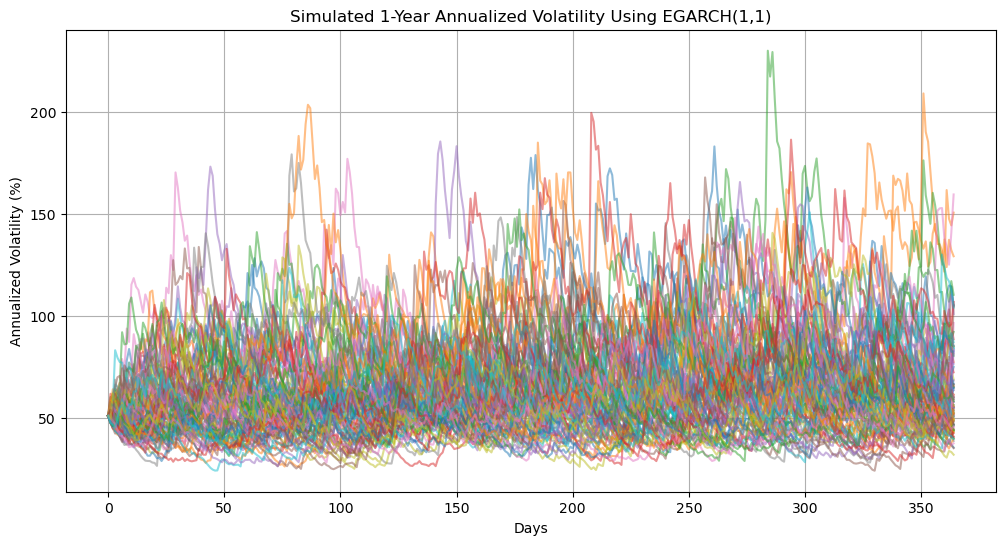

                           Constant Mean - EGARCH Model Results                           
Dep. Variable:                            BTC-USD   R-squared:                       0.000
Mean Model:                         Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                 EGARCH   Log-Likelihood:               -9503.94
Distribution:      Generalized Error Distribution   AIC:                           19017.9
Method:                        Maximum Likelihood   BIC:                           19049.1
                                                    No. Observations:                 3817
Date:                            Wed, Apr 02 2025   Df Residuals:                     3816
Time:                                    09:10:05   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
-----------------------------------

In [31]:
model = arch_model(btc_returns*100, vol='EGARCH', p=1, q=1, dist='ged') 
fit = model.fit(disp='off')  # Suppress output

n_days = 365  
n_simulations = 1000

# Forecast future volatility
forecast = fit.forecast(horizon=n_days, simulations=n_simulations, method='simulation')

# Extract simulated daily volatility 
simulated_volatility_daily = np.sqrt(forecast.simulations.variances) / 100

# Convert daily volatility to annualized volatility 
simulated_volatility_annualized = simulated_volatility_daily * np.sqrt(365)

plt.figure(figsize=(12, 6))

# Plot a subset of random paths for better visualization
for i in range(100):  
    plt.plot(simulated_volatility_annualized.T[:, i]*100, alpha=0.5)

plt.title("Simulated 1-Year Annualized Volatility Using EGARCH(1,1)")
plt.xlabel("Days")
plt.ylabel("Annualized Volatility (%)")
plt.grid(True)
plt.show()

print(fit.summary())


In [33]:
initial_price = btc_daily.iloc[-1] 
mu = np.array(historical_mean)  # Drift (annualized mean return) 
sigma = simulated_volatility_annualized[0,:].T  # Volatility (annualized standard deviation)
time_horizon = 1  # in year
steps_per_year = 365  # 365 for daily, 52 for weekly
num_simulations = 1000  

price_paths_egarch = simulate_gbm(initial_price, mu, sigma, time_horizon, steps_per_year, num_simulations)

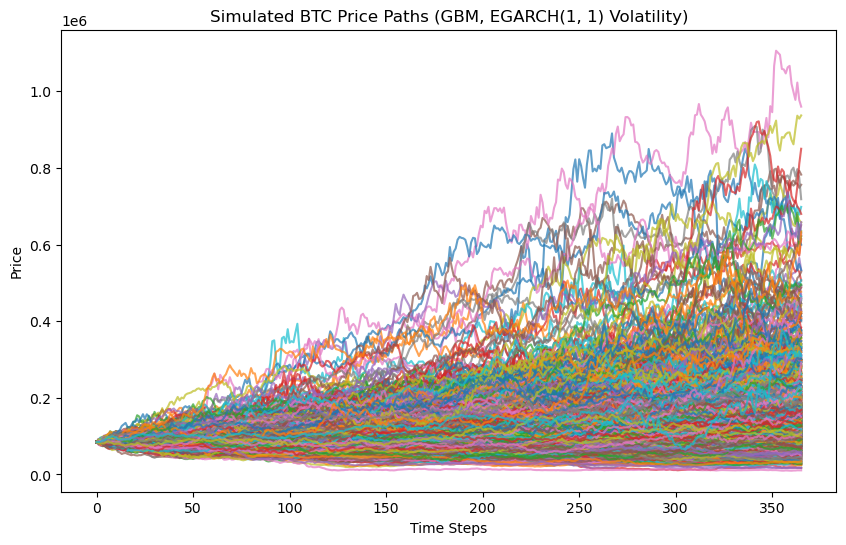

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(price_paths_egarch, alpha=0.7)
plt.title("Simulated BTC Price Paths (GBM, EGARCH(1, 1) Volatility)")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.show()

#### CPPI

In [36]:
cppi_results_egarch = cppi_strategy(price_paths_egarch, 0.04, multipliers, floor_fractions, initial_portfolio_value)

In [37]:
multiplier = 3
floor_frac = 0.8
key = (multiplier, floor_frac)

terminal_prices = price_paths_egarch[-1]  # Last row of price simulations
terminal_cppi = cppi_results_egarch[key]['Basket Values'][-1]  # Last row of CPPI basket values

#### OBPI

In [38]:
time_to_maturity = len(price_paths_egarch)/365  # adjust (52 for weekly, 365 for daily)

obpi_results_egarch = obpi_strategy(price_paths_egarch[:-1,:], 0.04, floor_fractions, initial_portfolio_value, time_to_maturity, simulated_volatility_annualized[0,].T) # time-varying sigma for the option pricing

#obpi_results_egarch = obpi_strategy(price_paths_egarch, 0.04, floor_fractions, initial_portfolio_value, time_to_maturity, float(historical_volatility.iloc[0])) # constant sigma for the option pricing

In [39]:
floor_frac_obpi = 1
key = (floor_frac_obpi)

terminal_prices = price_paths_egarch[-1]  # Last row of price simulations
terminal_obpi = obpi_results_egarch[key]['Basket Values'][-1]  # Last row of OBPI basket values

#### Buy & Hold

In [40]:
bnh_results_egarch = buy_and_hold_strategy(
    price_paths=price_paths_egarch,
    riskless_rate=0.04,
    initial_portfolio_value=100000,
    time_to_maturity=len(price_paths_egarch)/365
)

In [41]:
terminal_prices = price_paths_egarch[-1]  # Last row of price simulations
terminal_bnh = bnh_results_egarch['Basket Values'][-1]  # Last row of B&H basket values

#### Comparison

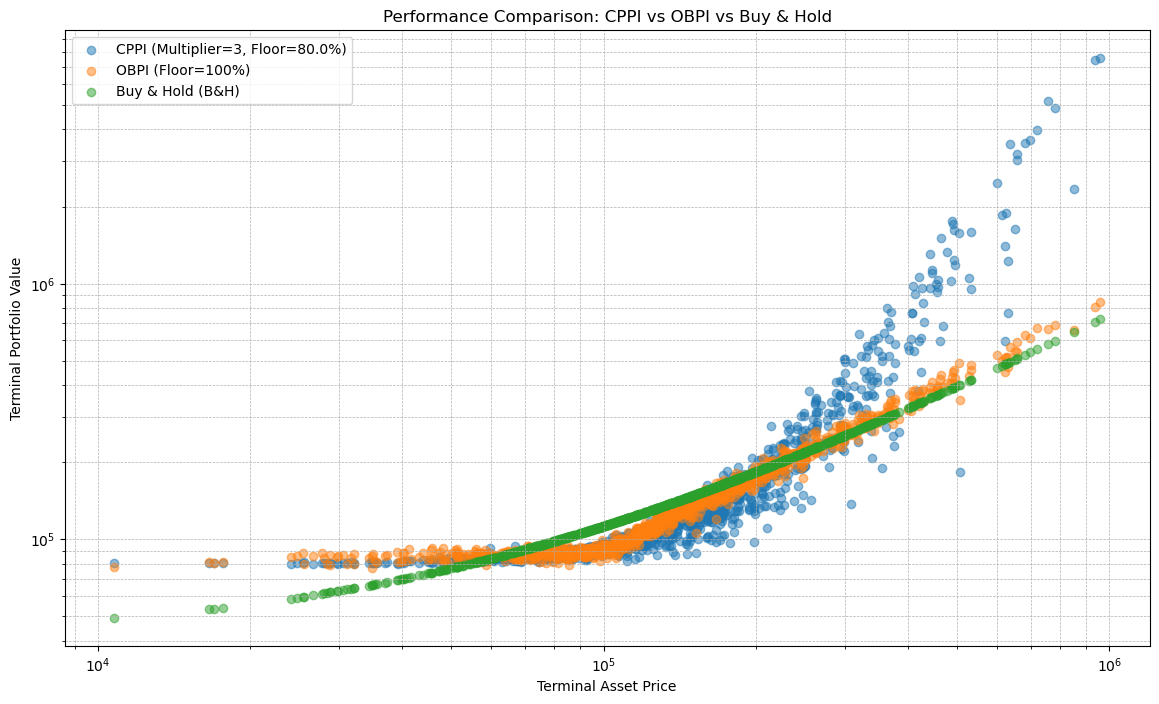

In [42]:
plt.figure(figsize=(14, 8))

# CPPI Outcomes 
plt.scatter(terminal_prices, terminal_cppi, 
            alpha=0.5, 
            label=f'CPPI (Multiplier={multiplier}, Floor={floor_frac*100}%)')

# OBPI Outcomes 
plt.scatter(terminal_prices, terminal_obpi, 
            alpha=0.5, 
            label=f'OBPI (Floor={floor_frac_obpi*100}%)')

# Buy & Hold Outcomes
plt.scatter(terminal_prices, terminal_bnh, 
            alpha=0.5, 
            label='Buy & Hold (B&H)')

plt.title('Performance Comparison: CPPI vs OBPI vs Buy & Hold')
plt.xlabel('Terminal Asset Price')
plt.xscale('log')  # Use log scale for better visualization
plt.ylabel('Terminal Portfolio Value')
plt.yscale('log')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [43]:
benchmark_prices = price_paths_egarch

# CPPI Strategy Performance
cppi_strategy_results = cppi_results_egarch[(3, 0.8)]
cppi_portfolio_values = np.array(cppi_strategy_results['Basket Values'])
cppi_metrics = performance(cppi_portfolio_values, benchmark_prices)
cppi_turnover = turnover(cppi_strategy_results['Risky Weights'])

# OBPI Strategy Performance
obpi_strategy_results = obpi_results_egarch[1]
obpi_portfolio_values = np.array(obpi_strategy_results['Basket Values'])
obpi_metrics = performance(obpi_portfolio_values, benchmark_prices[:-1,:]) # adjust [:-1,:]
obpi_turnover = turnover(obpi_strategy_results['Risky Weights'])

# Buy-and-Hold Strategy Performance
bnh_portfolio_values = np.array(bnh_results_egarch['Basket Values'])
bnh_metrics = performance(bnh_portfolio_values, benchmark_prices)
bnh_turnover = 0  # No turnover for B&H

# Display Results
def print_metrics(name, metrics, turnover):
    print(f"{name} Strategy Metrics:")
    for metric, value in metrics.items():
        print(f"{metric.replace('_', ' ').title()}: {value:.4f}")
    print(f"Turnover: {turnover:.2f}%\n")

print_metrics("CPPI", cppi_metrics, cppi_turnover)
print_metrics("OBPI", obpi_metrics, obpi_turnover)
print_metrics("Buy-and-Hold", bnh_metrics, bnh_turnover)

CPPI Strategy Metrics:
Annualized Return: 1.3640
Annualized Volatility: 0.5964
Sharpe Ratio: 1.1457
Sortino Ratio: 2.1648
Var 5: -0.0474
Es 5: -0.0702
Skewness: -0.1161
Kurtosis: 7.2771
Max Drawdown: -0.4049
Information Ratio: -0.6122
Turnover: 1324.55%

OBPI Strategy Metrics:
Annualized Return: 0.6014
Annualized Volatility: 0.3876
Sharpe Ratio: 1.0977
Sortino Ratio: 2.0979
Var 5: -0.0314
Es 5: -0.0442
Skewness: 0.0039
Kurtosis: 6.3862
Max Drawdown: -0.2834
Information Ratio: -1.2849
Turnover: 675.62%

Buy-and-Hold Strategy Metrics:
Annualized Return: 0.6474
Annualized Volatility: 0.4205
Sharpe Ratio: 1.4036
Sortino Ratio: 2.6109
Var 5: -0.0337
Es 5: -0.0455
Skewness: 0.1000
Kurtosis: 4.3937
Max Drawdown: -0.3061
Information Ratio: -1.2550
Turnover: 0.00%



In [44]:
print('BTC metrics:')
compute_btc_metrics(price_paths_egarch)

BTC metrics:


{'Annualized Return': '155.48%',
 'Annualized Volatility': '64.92%',
 'Sharpe Ratio': '2.41',
 'Sortino Ratio': '4.06',
 'VaR (5%)': '-5.18%',
 'Expected Shortfall (5%)': '-6.92%',
 'Skewness': '0.14',
 'Kurtosis': '1.25',
 'Max Drawdown': '-43.49%'}

## Merton Jump Diffusion

In [45]:
def simulate_merton_jump_diffusion(
    S0: float,               # Initial price
    mu: float,               # Annual drift
    sigma: float,            # Annual volatility (GBM part)
    lambd: float,            # Jump intensity (λ, jumps/year)
    mu_jump: float,          # Mean log-jump size (μ_J)
    sigma_jump: float,       # Jump size volatility (σ_J)
    T: float,                # Time horizon (years)
    steps: int,              # Number of time steps
    n_simulations: int,      # Number of paths
) -> np.ndarray:
    """
    Simulates price paths using Merton's Jump-Diffusion model.
    
    Returns:
        np.ndarray: Shape (steps + 1, n_simulations)
    """
    dt = T / steps  
    k = np.exp(mu_jump + 0.5 * sigma_jump**2) - 1  # Average jump size adjustment
    
    # Initialize price matrix
    S = np.zeros((steps + 1, n_simulations))
    S[0] = S0
    
    for t in range(1, steps + 1):
        # Poisson jumps 
        m = np.random.poisson(lambd * dt, n_simulations)
        
        # GBM component
        Z = np.random.randn(n_simulations)
        gbm = (mu - lambd * k - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
        
        # Jump component
        jump_sizes = np.zeros(n_simulations)
        for i in range(n_simulations):
            if m[i] > 0:
                # Sum of m[i] log-normal jumps
                jump_sizes[i] = np.sum(
                    mu_jump - 0.5 * sigma_jump**2 + sigma_jump * np.random.randn(m[i]))
        
        # Update price
        S[t] = S[t-1] * np.exp(gbm + jump_sizes)
    
    return S

In [46]:
params = {
    "S0": btc_daily.iloc[-1],              
    "mu": historical_mean.iloc[0],             # annual drift
    "sigma": historical_volatility.iloc[0],          # annual volatility (GBM)
    "lambd": 0.25,           # ~1 jump every 2 years
    "mu_jump": -0.3,        # Average jump drops price by ~x% (μ_J)
    "sigma_jump": 0.2,     # Jump size volatility (σ_J)
    "T": 1,                 
    "steps": 365,           # 365 for daily
    "n_simulations": 1000,
}

price_paths_jumps = simulate_merton_jump_diffusion(**params)

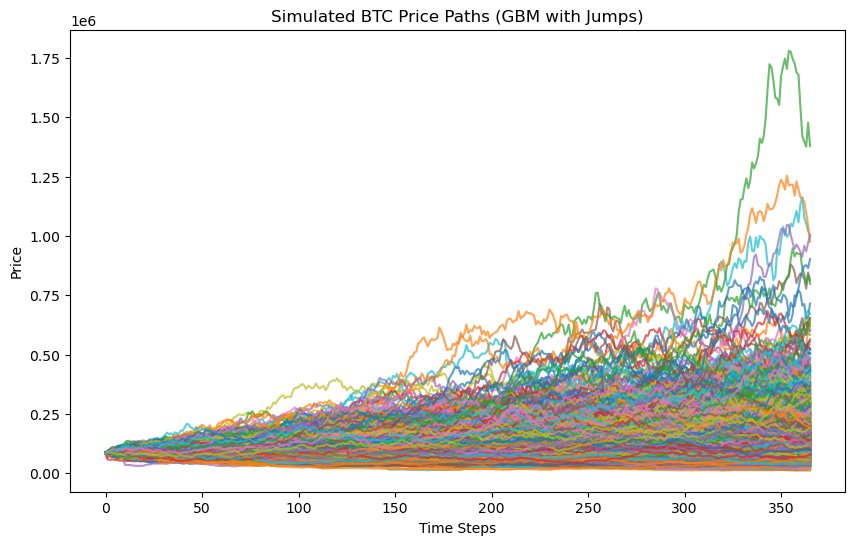

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(price_paths_jumps, alpha=0.7)
plt.title("Simulated BTC Price Paths (GBM with Jumps)")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.show()

#### CPPI

In [48]:
cppi_results_jumps = cppi_strategy(price_paths_jumps, 0.04, multipliers, floor_fractions, initial_portfolio_value)

In [49]:
multiplier = 3
floor_frac = 0.8
key = (multiplier, floor_frac)

terminal_prices = price_paths_jumps[-1]  # Last row of price simulations
terminal_cppi = cppi_results_jumps[key]['Basket Values'][-1]  # Last row of CPPI basket values

#### OBPI

In [50]:
time_to_maturity = len(price_paths_jumps)/365  # adjust (52 for weekly, 365 for daily)

# obpi_results_jumps = obpi_strategy(price_paths_jumps, 0.04, floor_fractions, initial_portfolio_value, time_to_maturity, float(historical_volatility.iloc[0])) 

# In the obpi strategy run above, the risky asset price paths follow a gbm with jumps process, but the option pricing model volatility is the historical volatility, hence constant. Is it better to use the historical_
# volatility or to use the simulated volatility paths obtained with EGARCH, hence dynamic volatility? 

obpi_results_jumps = obpi_strategy(price_paths_jumps[:-1,:], 0.04, floor_fractions, initial_portfolio_value, time_to_maturity, simulated_volatility_annualized[0,].T)

In [51]:
floor_frac_obpi = 1
key = (floor_frac_obpi)

terminal_prices = [-1]  # Last row of price simulations
terminal_obpi = obpi_results_jumps[key]['Basket Values'][-1]  # Last row of OBPI basket values

#### Buy & Hold

In [52]:
bnh_results_jumps = buy_and_hold_strategy(
    price_paths=price_paths_jumps,
    riskless_rate=0.04,
    initial_portfolio_value=100000,
    time_to_maturity=len(price_paths_jumps)/365
)

In [53]:
terminal_prices = price_paths_jumps[-1]  # Last row of price simulations
terminal_bnh = bnh_results_jumps['Basket Values'][-1]  # Last row of B&H basket values

#### Comparison

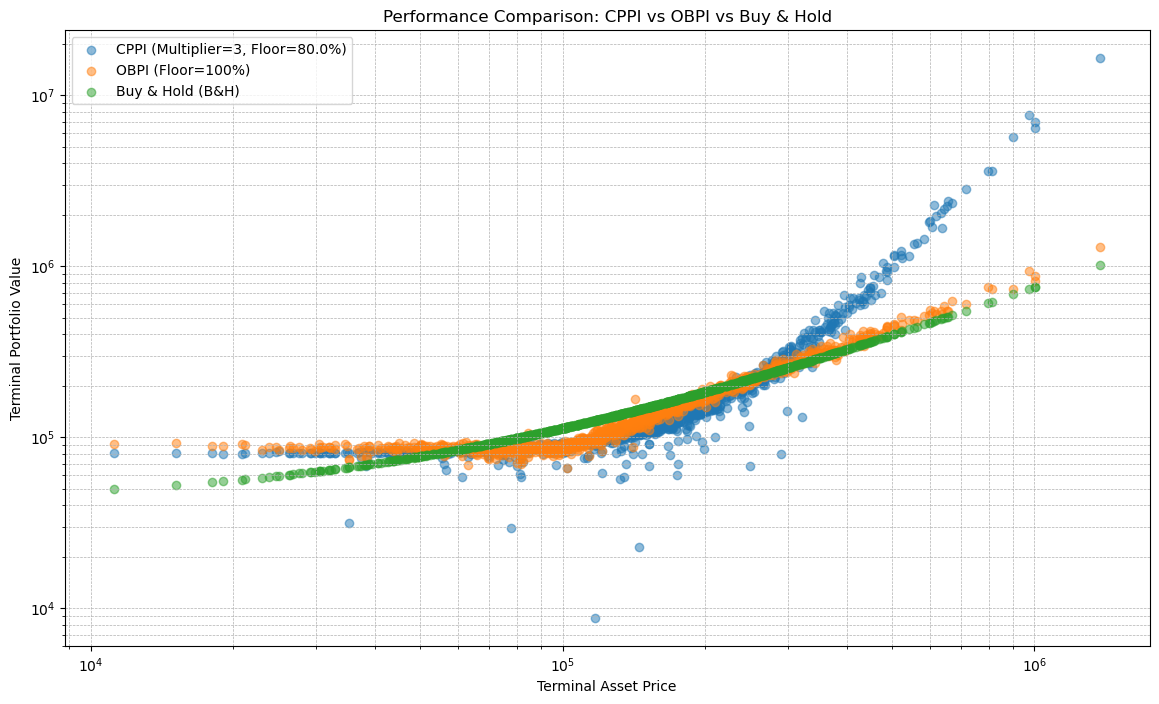

In [54]:
plt.figure(figsize=(14, 8))

# CPPI Outcomes 
plt.scatter(terminal_prices, terminal_cppi, 
            alpha=0.5, 
            label=f'CPPI (Multiplier={multiplier}, Floor={floor_frac*100}%)')

# OBPI Outcomes 
plt.scatter(terminal_prices, terminal_obpi, 
            alpha=0.5, 
            label=f'OBPI (Floor={floor_frac_obpi*100}%)')

# Buy & Hold Outcomes
plt.scatter(terminal_prices, terminal_bnh, 
            alpha=0.5, 
            label='Buy & Hold (B&H)')

plt.title('Performance Comparison: CPPI vs OBPI vs Buy & Hold')
plt.xlabel('Terminal Asset Price')
plt.xscale('log')  # Use log scale for better visualization
plt.ylabel('Terminal Portfolio Value')
plt.yscale('log')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [55]:
benchmark_prices = price_paths_jumps

# CPPI Strategy Performance
cppi_strategy_results = cppi_results_jumps[(3, 0.8)]
cppi_portfolio_values = np.array(cppi_strategy_results['Basket Values'])
cppi_metrics = performance(cppi_portfolio_values, benchmark_prices)
cppi_turnover = turnover(cppi_strategy_results['Risky Weights'])

# OBPI Strategy Performance
obpi_strategy_results = obpi_results_jumps[1]
obpi_portfolio_values = np.array(obpi_strategy_results['Basket Values'])
obpi_metrics = performance(obpi_portfolio_values, benchmark_prices[:-1,:]) # needed when using simulated volatility
obpi_turnover = turnover(obpi_strategy_results['Risky Weights'])

# Buy-and-Hold Strategy Performance
bnh_portfolio_values = np.array(bnh_results_jumps['Basket Values'])
bnh_metrics = performance(bnh_portfolio_values, benchmark_prices)
bnh_turnover = 0  # No turnover for B&H

# Display Results
def print_metrics(name, metrics, turnover):
    print(f"{name} Strategy Metrics:")
    for metric, value in metrics.items():
        print(f"{metric.replace('_', ' ').title()}: {value:.4f}")
    print(f"Turnover: {turnover:.2f}%\n")

print_metrics("CPPI", cppi_metrics, cppi_turnover)
print_metrics("OBPI", obpi_metrics, obpi_turnover)
print_metrics("Buy-and-Hold", bnh_metrics, bnh_turnover)

CPPI Strategy Metrics:
Annualized Return: 1.3780
Annualized Volatility: 0.6271
Sharpe Ratio: 0.9176
Sortino Ratio: 1.8027
Var 5: -0.0505
Es 5: -0.0724
Skewness: -0.8056
Kurtosis: 15.9904
Max Drawdown: -0.4281
Information Ratio: -0.6439
Turnover: 1387.61%

OBPI Strategy Metrics:
Annualized Return: 0.6085
Annualized Volatility: 0.4221
Sharpe Ratio: 0.9316
Sortino Ratio: 1.8223
Var 5: -0.0342
Es 5: -0.0472
Skewness: -0.5362
Kurtosis: 11.8532
Max Drawdown: -0.3116
Information Ratio: -1.2392
Turnover: 747.89%

Buy-and-Hold Strategy Metrics:
Annualized Return: 0.6570
Annualized Volatility: 0.4580
Sharpe Ratio: 1.2733
Sortino Ratio: 2.3784
Var 5: -0.0366
Es 5: -0.0475
Skewness: -0.2677
Kurtosis: 6.3898
Max Drawdown: -0.3325
Information Ratio: -1.1860
Turnover: 0.00%



In [56]:
print('BTC metrics:')
compute_btc_metrics(price_paths_jumps)

BTC metrics:


{'Annualized Return': '166.07%',
 'Annualized Volatility': '70.88%',
 'Sharpe Ratio': '2.36',
 'Sortino Ratio': '4.15',
 'VaR (5%)': '-5.63%',
 'Expected Shortfall (5%)': '-7.23%',
 'Skewness': '-0.18',
 'Kurtosis': '2.45',
 'Max Drawdown': '-47.08%'}

## Heston Model

In [57]:
def identity(x):
    return x

def heston_simulate(rate: float, sharpe_ratio: float, initial_price: float,
                    kappa: float, lt_var: float, vol_var: float, initial_var: float, rho: float,
                    n_paths: int, time_step: float, n_periods: int,
                    rng: np.random.Generator,
                    transform=identity):
    """
    Simulate paths for price and volatility under the Heston model.
    Note that this function has a side effect because it changes the state of the random number generator.
    """
    
    logS = np.empty((n_periods + 1, n_paths))  # Pre-allocate log prices
    V = np.empty((n_periods + 1, n_paths))  # Pre-allocate variances
    
    logS[0, :] = np.log(initial_price)  # Initial log price
    V[0, :] = initial_var  # Initial variance
    
    loading2 = np.sqrt(1 - rho**2)
    
    for i in range(1, n_periods + 1):
        std_innov1 = rng.standard_normal(n_paths)  # Standard normal innovations
        std_innov2 = rng.standard_normal(n_paths)
        
        sigma = np.sqrt(np.maximum(V[i - 1, :], 0))  # Ensure non-negative volatility
        
        logS[i, :] = logS[i - 1, :] + (rate + sharpe_ratio * sigma - 0.5 * V[i - 1, :]) * time_step \
            + sigma * np.sqrt(time_step) * std_innov1
            
        V[i, :] = V[i - 1, :] + kappa * (lt_var - V[i - 1, :]) * time_step \
            + vol_var * sigma * np.sqrt(time_step) * (rho * std_innov1 + loading2 * std_innov2)
            
        V[i, :] = transform(np.maximum(V[i, :], 0))  # Ensure variance is non-negative
    
    S = np.exp(logS)  # Convert log prices back to prices
    
    return {'price': S, 'volatility': np.sqrt(V)}

In [58]:
print(historical_mean)
print(historical_volatility)
print(historical_sharpe_ratio)

Ticker
BTC-USD    0.737998
dtype: float64
Ticker
BTC-USD    0.693099
dtype: float64
Ticker
BTC-USD    1.06478
dtype: float64


In [59]:
rate = 0.737998
initial_price = btc_daily.iloc[-1]
sharpe_ratio = 1.06478
kappa = 5.07
vol_var = .7
lt_var = 0.693099**2
initial_var = lt_var
rho = -0.767
n_paths = 1000
time_step = 1 / 365
n_periods = 365

rng = np.random.default_rng(seed=123)

SV = heston_simulate(rate, sharpe_ratio, initial_price,
                     kappa, lt_var, vol_var, initial_var, rho,
                     n_paths, time_step, n_periods,
                     rng)

In [60]:
price_paths_heston = SV['price']
vol_paths_heston = SV['volatility']

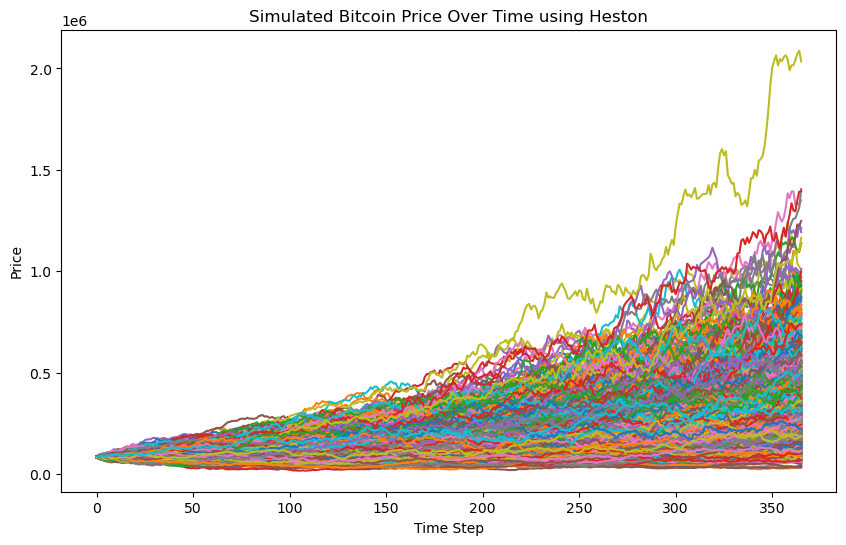

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(price_paths_heston)
plt.title("Simulated Bitcoin Price Over Time using Heston")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.show()

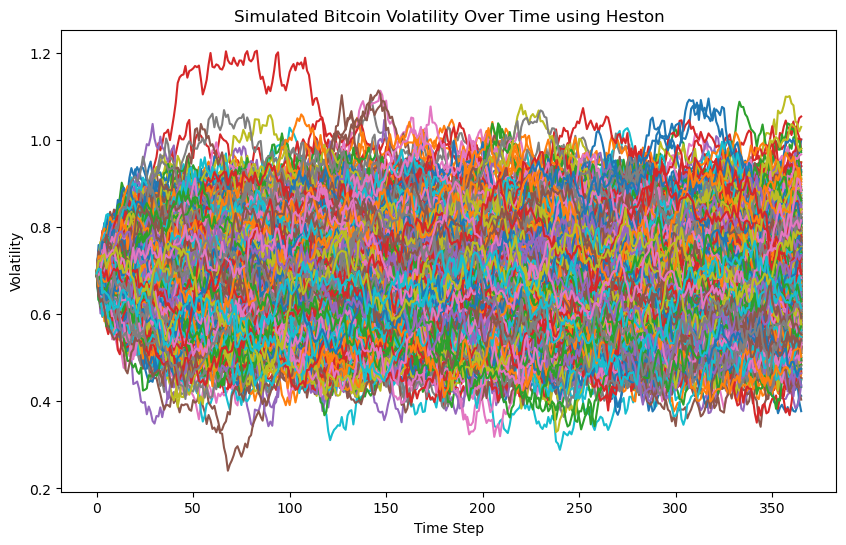

In [62]:
plt.figure(figsize=(10, 6))
plt.plot(vol_paths_heston)
plt.title("Simulated Bitcoin Volatility Over Time using Heston")
plt.xlabel("Time Step")
plt.ylabel("Volatility")
plt.show()

#### CPPI

In [63]:
cppi_results_heston = cppi_strategy(price_paths_heston, 0.04, multipliers, floor_fractions, initial_portfolio_value)

In [64]:
multiplier = 3
floor_frac = 0.8
key = (multiplier, floor_frac)

terminal_prices = price_paths_heston[-1]  # Last row of price simulations
terminal_cppi = cppi_results_heston[key]['Basket Values'][-1]  # Last row of CPPI basket values

#### OBPI

In [65]:
time_to_maturity = len(price_paths_heston)/365  # adjust (52 for weekly, 365 for daily)

# obpi_results_heston = obpi_strategy(price_paths_heston, 0.04, floor_fractions, initial_portfolio_value, time_to_maturity, float(historical_volatility.iloc[0]))
# same comment as before, above is historical volatility (constant) for the option pricing, and below is the volatility paths used for the risky asset simulation (dynamic)

obpi_results_heston = obpi_strategy(price_paths_heston, 0.04, floor_fractions, initial_portfolio_value, time_to_maturity, vol_paths_heston)

In [66]:
floor_frac_obpi = 1
key = (floor_frac_obpi)

terminal_prices = [-1]  # Last row of price simulations
terminal_obpi = obpi_results_heston[key]['Basket Values'][-1]  # Last row of OBPI basket values

#### Buy & Hold

In [67]:
bnh_results_heston = buy_and_hold_strategy(
    price_paths=price_paths_heston,
    riskless_rate=0.04,
    initial_portfolio_value=100000,
    time_to_maturity=len(price_paths_heston)/365
)

In [68]:
terminal_prices = price_paths_heston[-1]  # Last row of price simulations
terminal_bnh = bnh_results_heston['Basket Values'][-1]  # Last row of B&H basket values

#### Comparison

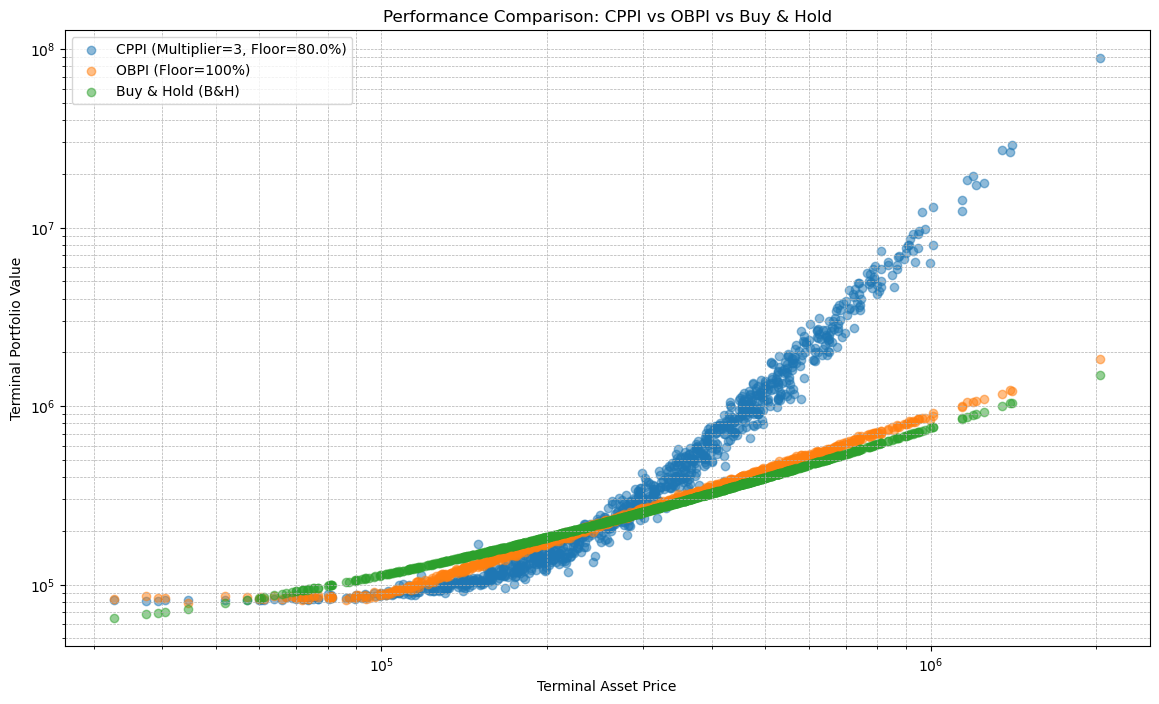

In [69]:
plt.figure(figsize=(14, 8))

# CPPI Outcomes 
plt.scatter(terminal_prices, terminal_cppi, 
            alpha=0.5, 
            label=f'CPPI (Multiplier={multiplier}, Floor={floor_frac*100}%)')

# OBPI Outcomes 
plt.scatter(terminal_prices, terminal_obpi, 
            alpha=0.5, 
            label=f'OBPI (Floor={floor_frac_obpi*100}%)')

# Buy & Hold Outcomes
plt.scatter(terminal_prices, terminal_bnh, 
            alpha=0.5, 
            label='Buy & Hold (B&H)')

plt.title('Performance Comparison: CPPI vs OBPI vs Buy & Hold')
plt.xlabel('Terminal Asset Price')
plt.xscale('log')  # Use log scale for better visualization
plt.ylabel('Terminal Portfolio Value')
plt.yscale('log')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [70]:
benchmark_prices = price_paths_heston

# CPPI Strategy Performance
cppi_strategy_results = cppi_results_heston[(3, 0.8)]
cppi_portfolio_values = np.array(cppi_strategy_results['Basket Values'])
cppi_metrics = performance(cppi_portfolio_values, benchmark_prices)
cppi_turnover = turnover(cppi_strategy_results['Risky Weights'])

# OBPI Strategy Performance
obpi_strategy_results = obpi_results_heston[1]
obpi_portfolio_values = np.array(obpi_strategy_results['Basket Values'])
obpi_metrics = performance(obpi_portfolio_values, benchmark_prices)
obpi_turnover = turnover(obpi_strategy_results['Risky Weights'])

# Buy-and-Hold Strategy Performance
bnh_portfolio_values = np.array(bnh_results_heston['Basket Values'])
bnh_metrics = performance(bnh_portfolio_values, benchmark_prices)
bnh_turnover = 0  # No turnover for B&H

# Display Results
def print_metrics(name, metrics, turnover):
    print(f"{name} Strategy Metrics:")
    for metric, value in metrics.items():
        print(f"{metric.replace('_', ' ').title()}: {value:.4f}")
    print(f"Turnover: {turnover:.2f}%\n")

print_metrics("CPPI", cppi_metrics, cppi_turnover)
print_metrics("OBPI", obpi_metrics, obpi_turnover)
print_metrics("Buy-and-Hold", bnh_metrics, bnh_turnover)

CPPI Strategy Metrics:
Annualized Return: 10.4920
Annualized Volatility: 0.9580
Sharpe Ratio: 8.1093
Sortino Ratio: 15.9169
Var 5: -0.0759
Es 5: -0.1031
Skewness: 0.0975
Kurtosis: 4.7060
Max Drawdown: -0.5022
Information Ratio: 0.3359
Turnover: 1601.85%

OBPI Strategy Metrics:
Annualized Return: 2.0996
Annualized Volatility: 0.5186
Sharpe Ratio: 3.8397
Sortino Ratio: 7.4061
Var 5: -0.0406
Es 5: -0.0533
Skewness: 0.1374
Kurtosis: 3.9865
Max Drawdown: -0.3000
Information Ratio: -1.8796
Turnover: 499.30%

Buy-and-Hold Strategy Metrics:
Annualized Return: 1.9311
Annualized Volatility: 0.4911
Sharpe Ratio: 3.8851
Sortino Ratio: 7.5001
Var 5: -0.0382
Es 5: -0.0486
Skewness: 0.1120
Kurtosis: 3.2038
Max Drawdown: -0.2847
Information Ratio: -2.2298
Turnover: 0.00%



In [71]:
print('BTC metrics:')
compute_btc_metrics(price_paths_heston)

BTC metrics:


{'Annualized Return': '426.40%',
 'Annualized Volatility': '69.09%',
 'Sharpe Ratio': '6.42',
 'Sortino Ratio': '11.59',
 'VaR (5%)': '-5.35%',
 'Expected Shortfall (5%)': '-6.77%',
 'Skewness': '0.14',
 'Kurtosis': '0.19',
 'Max Drawdown': '-37.85%'}

## Robustness analysis

Going forward, we will only use GBM with constant volatility.

### Impact of rebalancing frequency

In [72]:
def simulate_gbm_robustness_rebalancing(initial_price, mu, sigma, time_horizon, steps_per_year_array, num_simulations):
    """
    Simulates asset price evolution using Geometric Brownian Motion (GBM) with multiple time steps.

    Parameters:
        initial_price (float): Current asset price.
        mu (float): Drift (mean return).
        sigmas (float): Annualized volatility.
        time_horizon (float): Time horizon in years.
        steps_per_year_array (list): Array of time steps per year (e.g., [365, 52, 24, 12, 4]).
        num_simulations (int): Number of Monte Carlo simulations.

    Returns:
        dict: Dictionary of simulated price paths for each steps_per_year.
    """
    results = {}

    for steps_per_year in steps_per_year_array:
        dt = 1 / steps_per_year
        total_steps = int(time_horizon * steps_per_year)

        # Initialize price paths
        price_paths = np.zeros((total_steps + 1, num_simulations))
        price_paths[0] = initial_price

        for t in range(1, total_steps + 1):
            z = np.random.standard_normal(num_simulations)
            price_paths[t] = price_paths[t - 1] * np.exp(
                (mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z
            )

        results[steps_per_year] = price_paths

    return results

In [73]:
steps_per_year_array = [365, 52, 24, 12, 4]

In [74]:
initial_price = btc_daily.iloc[-1]  
mu = historical_mean.iloc[0]  # Drift (annualized mean return) 
sigma = historical_volatility.iloc[0]  # Volatility (annualized standard deviation)
time_horizon = 1  # in year
steps_per_year = steps_per_year_array 
num_simulations = 1000 

price_paths_robustness_rebalancing = simulate_gbm_robustness_rebalancing(initial_price, mu, sigma, time_horizon, steps_per_year, num_simulations)

#### CPPI

In [75]:
def cppi_strategy_robustness_rebalacing(risky_asset, riskless_rate, multipliers, floor_fractions, initial_portfolio_value):

    results = {}

    # Loop through each rebalancing frequency
    for frequency, asset_prices in risky_asset.items():
        # Get the shape of the price matrix 
        n_steps, n_simulations = asset_prices.shape

        # Adjusted risk-free rate per rebalancing period
        riskless_return = (1 + riskless_rate) ** (1 / frequency) - 1

        results[frequency] = {}

        # Loop through each multiplier and floor fraction combination
        for multiplier in multipliers:
            for floor_fraction in floor_fractions:
                # Initialize arrays 
                basket_values = np.zeros((n_steps, n_simulations))
                risky_weights = np.zeros((n_steps, n_simulations))
                riskless_weights = np.zeros((n_steps, n_simulations))

                # Initial conditions
                basket_values[0] = initial_portfolio_value
                floor = initial_portfolio_value * floor_fraction

                # Compute the initial cushion and weights
                initial_cushion = np.maximum(basket_values[0] - floor, 0) / basket_values[0]
                risky_weights[0] = np.maximum(multiplier * initial_cushion, 0)
                riskless_weights[0] = 1 - risky_weights[0]

                # CPPI dynamics: update at the specified rebalancing interval
                for t in range(1, n_steps):
                    # Compute risky returns 
                    risky_returns = (asset_prices[t] - asset_prices[t - 1]) / asset_prices[t - 1]

                    # Portfolio return: combine risky and riskless returns
                    port_returns = (risky_weights[t - 1] * risky_returns +
                                    riskless_weights[t - 1] * riskless_return)

                    # Update portfolio value
                    basket_values[t] = basket_values[t - 1] * (1 + port_returns)

                
                    cushion = np.maximum(basket_values[t] - floor, 0) / basket_values[t]
                    risky_weights[t] = np.maximum(multiplier * cushion, 0)
                    riskless_weights[t] = 1 - risky_weights[t]

                results[frequency][(multiplier, floor_fraction)] = {
                    'Basket Values': basket_values,
                    'Risky Weights': risky_weights,
                    'Riskless Weights': riskless_weights
                }

    return results

In [76]:
cppi_results_robustness_rebalancing = cppi_strategy_robustness_rebalacing(price_paths_robustness_rebalancing, 0.04, multipliers, floor_fractions, initial_portfolio_value)

In [77]:
key = steps_per_year_array[2]  # Chosen as example

terminal_prices = price_paths_robustness_rebalancing[key][-1]  # Last row of price simulations
terminal_cppi = cppi_results_robustness_rebalancing[key][(3, 0.8)]['Basket Values'][-1]  # Last row of CPPI basket values

In [78]:
def compute_metrics_cppi_rebalancing(cppi_results, m=3, f=0.8, riskless_rate=0.04):
    """
    Computes the average return, volatility, and Sharpe ratio for each rebalancing frequency
    for a specific multiplier and floor fraction.

    Parameters:
        cppi_results (dict): Output from the cppi_strategy_robustness_rebalancing function.
        m (int or float): The multiplier (e.g., 3).
        f (float): The floor fraction (e.g., 0.8).
        riskless_rate (float): The annual risk-free rate (e.g., 0.04 for 4%).

    Returns:
        dict: A dictionary containing average returns, volatility, and Sharpe ratios for each rebalancing frequency.
    """
    avg_returns = {}
    volatility = {}
    sharpe_ratios = {}

    # Loop through each rebalancing frequency 
    for frequency, freq_results in cppi_results.items():
        # Check if (m, f) combination exists for this frequency
        if (m, f) in freq_results:
            # Extract the basket values for the specified (m, f)
            basket_values = freq_results[(m, f)]['Basket Values']

            # Calculate returns across simulations (percentage change from one period to the next)
            basket_values_ret = basket_values[1:, :] / basket_values[:-1, :] - 1  

            # Calculate final and initial values for returns
            final_values = basket_values[-1, :]  # Final value (last time step)
            initial_values = basket_values[0, :]  # Initial value (first time step)

            # Compute returns for each simulation
            returns = (final_values - initial_values) / initial_values

            # Calculate average return for the frequency
            avg_returns[frequency] = np.mean(returns)

            # Calculate volatility (standard deviation of returns across simulations)
            volatility[frequency] = np.std(basket_values_ret, axis=1) * np.sqrt(frequency) 

            # Mean volatility across all time steps
            volatility[frequency] = np.mean(volatility[frequency])

            # Calculate Sharpe ratio: (Average return - Risk-free rate) / Volatility
            sharpe_ratios[frequency] = (avg_returns[frequency] - riskless_rate) / volatility[frequency] if volatility[frequency] != 0 else np.nan

    return {
        "Average Returns": avg_returns,
        "Volatility": volatility,
        "Sharpe Ratios": sharpe_ratios
    }

In [79]:
results_cppi = compute_metrics_cppi_rebalancing(cppi_results_robustness_rebalancing)

print("Average Returns:", results_cppi["Average Returns"])
print("Volatility:", results_cppi["Volatility"])
print("Sharpe Ratios:", results_cppi["Sharpe Ratios"])

Average Returns: {365: 1.790217837443732, 52: 1.3342219342075363, 24: 1.7732604029239376, 12: 1.450587484898869, 4: 1.1577397164476508}
Volatility: {365: 0.7239018904486401, 52: 0.7212919229130476, 24: 0.7429508463705474, 12: 0.776882600224598, 4: 0.8555013595926939}
Sharpe Ratios: {365: 2.417755583369219, 52: 1.7943108651218822, 24: 2.332940882147501, 12: 1.8157022495948112, 4: 1.306531782696183}


#### OBPI

In [80]:
def obpi_strategy_robustness_rebalancing(risky_asset, riskless_rate, floor_fractions, initial_portfolio_value, time_to_maturity, sigma):
    """
    Implements the OBPI (Option-Based Portfolio Insurance) strategy for multiple floor fractions and rebalancing frequencies.

    Parameters:
        risky_asset (dict): Dictionary where keys are rebalancing frequencies (e.g., 365 for daily, 52 for weekly)
                             and values are simulated risky asset prices with shape (n_steps, n_simulations).
        riskless_rate (float): The constant annual risk-free rate (e.g., 0.02 for 2%).
        floor_fractions (list): List of floor fractions to test.
        initial_portfolio_value (float): Initial value of the portfolio.
        time_to_maturity (float): Time to maturity in years.
        sigma (float or ndarray): Volatility of the risky asset (annualized), either a float (constant) or ndarray (n_steps, n_simulations).

    Returns:
        dict: Dictionary containing results for each floor fraction and each rebalancing frequency.
    """
    results = {}

    def black_scholes_put(S, K, T, r, sigma):
        """Computes the Black-Scholes put price and delta."""
        if T <= 0:  # Handle edge case where time to maturity is zero
            return np.maximum(K - S, 0), np.where(S < K, -1, 0)  # Vectorized for arrays
        
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        
        put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        put_delta = -norm.cdf(-d1)
        
        return put_price, put_delta

    # Loop through all rebalancing frequencies 
    for frequency, asset_prices in risky_asset.items():
        n_steps, n_simulations = asset_prices.shape
        floor_results = {}

        # Calculate riskless return based on frequency
        riskless_return = (1 + riskless_rate) ** (1 / frequency) - 1
        dt = 1 / frequency  

        for floor_fraction in floor_fractions:
            # Initialize arrays 
            basket_values = np.zeros((n_steps, n_simulations))
            risky_weights = np.zeros((n_steps, n_simulations))
            riskless_weights = np.zeros((n_steps, n_simulations))
            put_prices = np.zeros((n_steps, n_simulations))
            put_deltas = np.zeros((n_steps, n_simulations))

            # Initial conditions
            floor = initial_portfolio_value * floor_fraction

            # Compute initial put price and delta for all simulations
            initial_put_price, initial_put_delta = black_scholes_put(
                asset_prices[0], floor, time_to_maturity, riskless_rate, sigma
            )

            # Compute initial weights
            risky_w = ((1 + initial_put_delta) * asset_prices[0]) / (asset_prices[0] + initial_put_price)
            risky_w = np.maximum(0, np.minimum(1, risky_w))  # Ensure weights are between 0 and 1
            riskless_w = 1 - risky_w

            # Set initial values
            basket_values[0, :] = initial_portfolio_value
            risky_weights[0, :] = risky_w
            riskless_weights[0, :] = riskless_w
            put_prices[0, :] = initial_put_price
            put_deltas[0, :] = initial_put_delta

            for i in range(1, n_steps):
                remaining_ttm = time_to_maturity - i * dt  

                # Compute risky returns
                risky_return = (asset_prices[i] - asset_prices[i - 1]) / asset_prices[i - 1]

                # Update portfolio value
                portfolio_return = (risky_weights[i - 1] * risky_return +
                                    riskless_weights[i - 1] * riskless_return)
                basket_values[i] = basket_values[i - 1] * (1 + portfolio_return)

                # Compute new put option price and delta 
                put_price, put_delta = black_scholes_put(
                    asset_prices[i], floor, remaining_ttm, riskless_rate, sigma
                )

                # Update weights
                risky_w = ((1 + put_delta) * asset_prices[i]) / (asset_prices[i] + put_price)
                risky_w = np.maximum(0, np.minimum(1, risky_w))  # Ensure weights are between 0 and 1
                riskless_w = 1 - risky_w

                # Store values for this step
                risky_weights[i] = risky_w
                riskless_weights[i] = riskless_w
                put_prices[i] = put_price
                put_deltas[i] = put_delta

            floor_results[floor_fraction] = {
                "Basket Values": basket_values,
                "Risky Weights": risky_weights,
                "Riskless Weights": riskless_weights,
                "Put Price": put_prices,
                "Put Delta": put_deltas,
            }

        results[frequency] = floor_results

    return results

In [81]:
obpi_results_robustness_rebalancing = obpi_strategy_robustness_rebalancing(price_paths_robustness_rebalancing, 0.04, floor_fractions, initial_portfolio_value, 1, historical_volatility.iloc[0])

In [82]:
key = steps_per_year_array[2]  # Example

terminal_prices = price_paths_robustness_rebalancing[key][-1]  # Last row of price simulations
terminal_obpi = obpi_results_robustness_rebalancing[key][1]['Basket Values'][-1]  # Last row of OBPI basket values

In [83]:
def compute_metrics_obpi(results, f=1, riskless_rate=0.04):
    """
    Computes the average return, volatility, and Sharpe ratio for each rebalancing frequency
    for a specific floor fraction.

    Parameters:
        results (dict): Output from the obpi_strategy_robustness_rebalancing function.
        f (float): The floor fraction (e.g., 1).
        riskless_rate (float): The annual risk-free rate (e.g., 0.04 for 4%).

    Returns:
        dict: A dictionary containing average returns, volatility, and Sharpe ratios for each rebalancing frequency.
    """
    avg_returns = {}
    volatility = {}
    sharpe_ratios = {}

    # Loop through each rebalancing frequency 
    for frequency, freq_results in results.items():
        # Check if (f) exists for this frequency
        if f in freq_results:
            # Extract the basket values for the specified (f)
            basket_values = freq_results[f]['Basket Values']

            # Calculate returns across simulations (percentage change from one period to the next)
            basket_values_ret = basket_values[1:, :] / basket_values[:-1, :] - 1  

            # Calculate final and initial values for returns
            final_values = basket_values[-1, :]  # Final value (last time step)
            initial_values = basket_values[0, :]  # Initial value (first time step)

            # Compute returns for each simulation
            returns = (final_values - initial_values) / initial_values

            # Calculate average return for the frequency
            avg_returns[frequency] = np.mean(returns)

            # Calculate volatility (standard deviation of returns across simulations)
            volatility[frequency] = np.std(basket_values_ret, axis=1) * np.sqrt(frequency) 

            # Mean volatility across all time steps
            volatility[frequency] = np.mean(volatility[frequency])

            # Calculate Sharpe ratio: (Average return - Risk-free rate) / Volatility
            sharpe_ratios[frequency] = (avg_returns[frequency] - riskless_rate) / volatility[frequency] if volatility[frequency] != 0 else np.nan

    return {
        "Average Returns": avg_returns,
        "Volatility": volatility,
        "Sharpe Ratios": sharpe_ratios
    }

In [84]:
results_obpi = compute_metrics_obpi(obpi_results_robustness_rebalancing)

print("Average Returns:", results_obpi["Average Returns"])
print("Volatility:", results_obpi["Volatility"])
print("Sharpe Ratios:", results_obpi["Sharpe Ratios"])

Average Returns: {365: 0.668408450808167, 52: 0.5935233729291344, 24: 0.6455277988867938, 12: 0.6230390619667514, 4: 0.5974405319659863}
Volatility: {365: 0.43832828318187667, 52: 0.43520092992241943, 24: 0.44652064551740445, 12: 0.4619298196343535, 4: 0.5052168929308012}
Sharpe Ratios: {365: 1.4336479641388322, 52: 1.2718800325812896, 24: 1.356102578829564, 12: 1.2621810439262473, 4: 1.10336875066119}


### Analysis

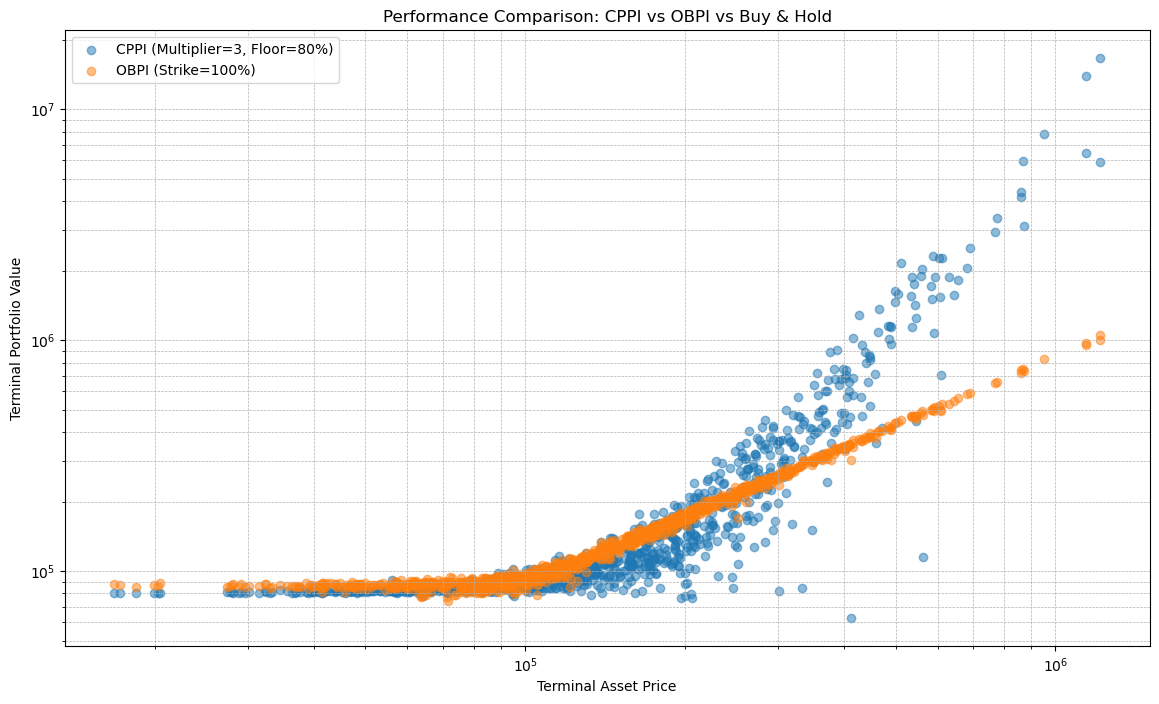

In [85]:
plt.figure(figsize=(14, 8))

# CPPI Outcomes 
plt.scatter(terminal_prices, terminal_cppi, 
            alpha=0.5, 
            label='CPPI (Multiplier=3, Floor=80%)')

# OBPI Outcomes 
plt.scatter(terminal_prices, terminal_obpi, 
            alpha=0.5, 
            label='OBPI (Strike=100%)')

plt.title('Performance Comparison: CPPI vs OBPI vs Buy & Hold')
plt.xlabel('Terminal Asset Price')
plt.xscale('log')  # Use log scale for better visualization
plt.ylabel('Terminal Portfolio Value')
plt.yscale('log')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [86]:
# Extract rebalancing frequencies
frequencies_cppi = list(results_cppi["Average Returns"].keys())
frequencies_obpi = list(results_obpi["Average Returns"].keys())

# Get the values for average returns, volatility, and Sharpe ratios
avg_returns_cppi = [results_cppi["Average Returns"][f] for f in frequencies_cppi]
volatility_cppi = [results_cppi["Volatility"][f] for f in frequencies_cppi]
sharpe_cppi = [results_cppi["Sharpe Ratios"][f] for f in frequencies_cppi]

avg_returns_obpi = [results_obpi["Average Returns"][f] for f in frequencies_obpi]
volatility_obpi = [results_obpi["Volatility"][f] for f in frequencies_obpi]
sharpe_obpi = [results_obpi["Sharpe Ratios"][f] for f in frequencies_obpi]

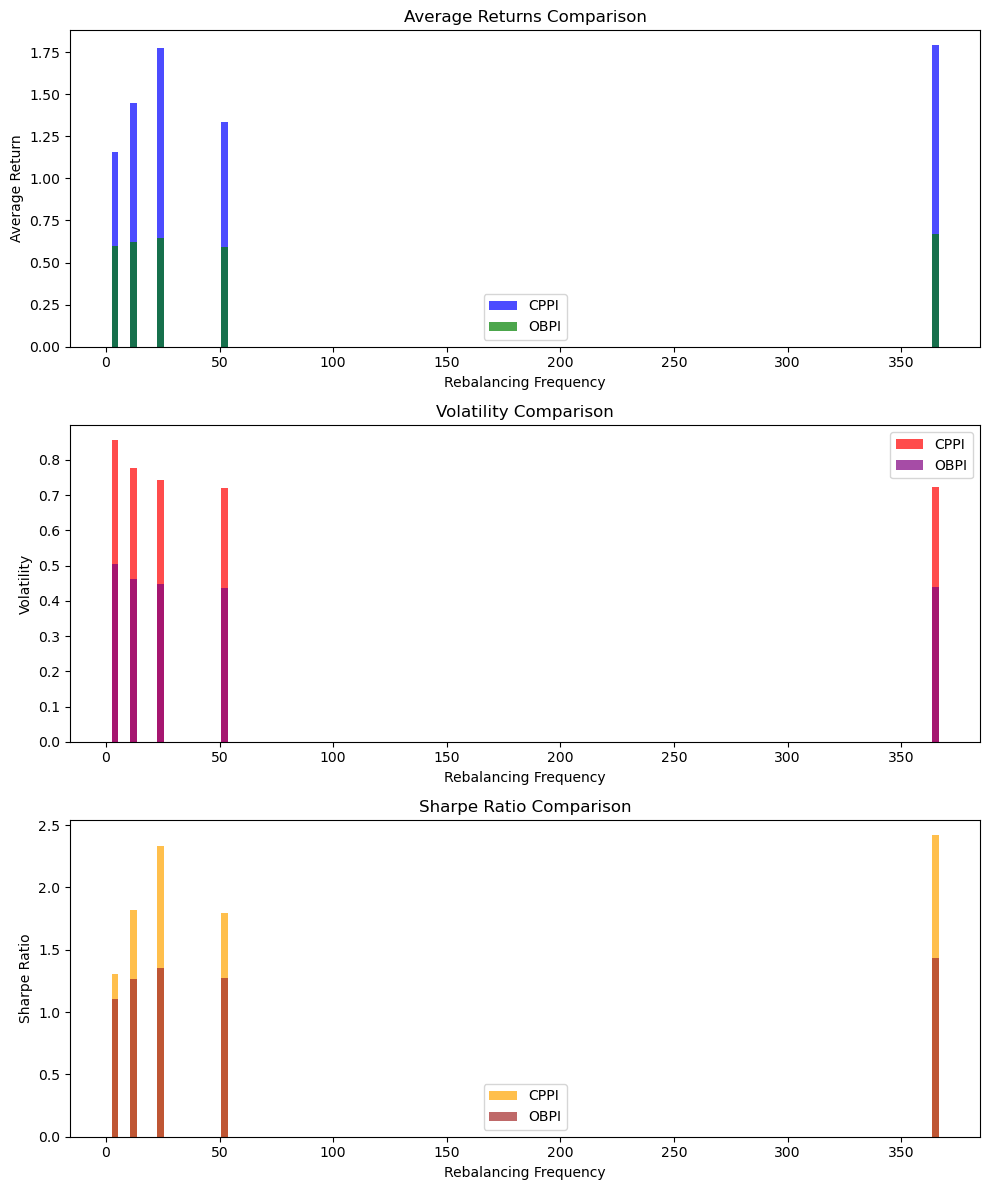

In [87]:
# Create subplots: 3 rows for Average Return, Volatility, and Sharpe Ratio
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# Bar chart for Average Returns
axes[0].bar(frequencies_cppi, avg_returns_cppi, width=3, label='CPPI', alpha=0.7, color='blue')
axes[0].bar(frequencies_obpi, avg_returns_obpi, width=3, label='OBPI', alpha=0.7, color='green')
axes[0].set_title('Average Returns Comparison')
axes[0].set_xlabel('Rebalancing Frequency')
axes[0].set_ylabel('Average Return')
axes[0].legend()

# Bar chart for Volatility
axes[1].bar(frequencies_cppi, volatility_cppi, width=3, label='CPPI', alpha=0.7, color='red')
axes[1].bar(frequencies_obpi, volatility_obpi, width=3, label='OBPI', alpha=0.7, color='purple')
axes[1].set_title('Volatility Comparison')
axes[1].set_xlabel('Rebalancing Frequency')
axes[1].set_ylabel('Volatility')
axes[1].legend()

# Bar chart for Sharpe Ratios
axes[2].bar(frequencies_cppi, sharpe_cppi, width=3, label='CPPI', alpha=0.7, color='orange')
axes[2].bar(frequencies_obpi, sharpe_obpi, width=3, label='OBPI', alpha=0.7, color='brown')
axes[2].set_title('Sharpe Ratio Comparison')
axes[2].set_xlabel('Rebalancing Frequency')
axes[2].set_ylabel('Sharpe Ratio')
axes[2].legend()

plt.tight_layout()
plt.show()

### Impact of volatility level

In [88]:
def simulate_gbm_robustness_volatility(initial_price, mu, sigmas, time_horizon, steps_per_year, num_simulations):
    
    results = {}

    for sigma in sigmas:
        dt = 1 / steps_per_year
        total_steps = int(time_horizon * steps_per_year)

        # Initialize price paths
        price_paths = np.zeros((total_steps + 1, num_simulations))
        price_paths[0] = initial_price

        for t in range(1, total_steps + 1):
            z = np.random.standard_normal(num_simulations)
            price_paths[t] = price_paths[t - 1] * np.exp(
                (mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z
            )

        results[sigma] = price_paths

    return results

In [89]:
sigmas = [2, 1.5, 1, 0.5, 0.25]

In [90]:
initial_price = btc_daily.iloc[-1]  
mu = historical_mean.iloc[0]  # Drift (annualized mean return) 
sigma = sigmas  # Volatilities
time_horizon = 1  # in year
steps_per_year = 365 
num_simulations = 1000 

price_paths_robustness_volatility = simulate_gbm_robustness_volatility(initial_price, mu, sigma, time_horizon, steps_per_year, num_simulations)

#### CPPI

In [91]:
def cppi_strategy_robustness_volatility(risky_asset, riskless_rate, multipliers, floor_fractions, initial_portfolio_value):

    results = {}

    # Loop through each volatility
    for volatility, asset_prices in risky_asset.items():
        # Get the shape of the price matrix for the current volatility
        n_steps, n_simulations = asset_prices.shape

        # Adjusted risk-free rate per rebalancing period
        riskless_return = (1 + riskless_rate) ** (1 / 365) - 1

        # Store results for the current volatility
        results[volatility] = {}

        # Loop through each multiplier and floor fraction combination
        for multiplier in multipliers:
            for floor_fraction in floor_fractions:
                # Initialize arrays for portfolio values and weights
                basket_values = np.zeros((n_steps, n_simulations))
                risky_weights = np.zeros((n_steps, n_simulations))
                riskless_weights = np.zeros((n_steps, n_simulations))

                # Initial conditions
                basket_values[0] = initial_portfolio_value
                floor = initial_portfolio_value * floor_fraction

                # Compute the initial cushion and weights
                initial_cushion = np.maximum(basket_values[0] - floor, 0) / basket_values[0]
                risky_weights[0] = np.maximum(multiplier * initial_cushion, 0)
                riskless_weights[0] = 1 - risky_weights[0]

                # CPPI dynamics: update at the specified rebalancing interval
                for t in range(1, n_steps):
                    # Compute risky returns since the last step
                    risky_returns = (asset_prices[t] - asset_prices[t - 1]) / asset_prices[t - 1]

                    # Portfolio return: combine risky and riskless returns
                    port_returns = (risky_weights[t - 1] * risky_returns +
                                    riskless_weights[t - 1] * riskless_return)

                    # Update portfolio value
                    basket_values[t] = basket_values[t - 1] * (1 + port_returns)

                
                    cushion = np.maximum(basket_values[t] - floor, 0) / basket_values[t]
                    risky_weights[t] = np.maximum(multiplier * cushion, 0)
                    riskless_weights[t] = 1 - risky_weights[t]

                # Store the results for the current volatility, multiplier, and floor_fraction
                results[volatility][(multiplier, floor_fraction)] = {
                    'Basket Values': basket_values,
                    'Risky Weights': risky_weights,
                    'Riskless Weights': riskless_weights
                }

    return results

In [92]:
cppi_results_robustness_volatility = cppi_strategy_robustness_volatility(price_paths_robustness_volatility, 0.04, multipliers, floor_fractions, initial_portfolio_value)

In [93]:
key = sigmas[2]  # Example

terminal_prices = price_paths_robustness_volatility[key][-1]  # Last row of price simulations
terminal_cppi = cppi_results_robustness_volatility[key][(3, 0.8)]['Basket Values'][-1]  # Last row of CPPI basket values

In [94]:
def compute_metrics_cppi_volatility(cppi_results, m=3, f=0.8, riskless_rate=0.04):
    """
    Computes the average return, volatility, and Sharpe ratio for each  volatility
    for a specific multiplier and floor fraction.

    Parameters:
        cppi_results (dict): Output from the cppi_strategy_robustness_rebalancing function.
        m (int or float): The multiplier (e.g., 3).
        f (float): The floor fraction (e.g., 0.8).
        riskless_rate (float): The annual risk-free rate (e.g., 0.04 for 4%).

    Returns:
        dict: A dictionary containing average returns, volatility, and Sharpe ratios for each rebalancing frequency.
    """
    avg_returns = {}
    volatilities = {}
    sharpe_ratios = {}

    # Loop through each volatility level
    for volatility, freq_results in cppi_results.items():
        # Check if (m, f) combination exists for this volatility
        if (m, f) in freq_results:
            # Extract the basket values for the specified (m, f)
            basket_values = freq_results[(m, f)]['Basket Values']

            # Calculate returns across simulations (percentage change from one period to the next)
            basket_values_ret = basket_values[1:, :] / basket_values[:-1, :] - 1  # Percentage change between consecutive values

            # Calculate final and initial values for returns
            final_values = basket_values[-1, :]  # Final value (last time step)
            initial_values = basket_values[0, :]  # Initial value (first time step)

            # Compute returns for each simulation
            returns = (final_values - initial_values) / initial_values

            # Calculate average return for the volatility
            avg_returns[volatility] = np.mean(returns)

            # Calculate volatility (standard deviation of returns across simulations)
            # Calculate the standard deviation of the returns for each time step across simulations
            volatilities[volatility] = np.std(basket_values_ret, axis=1) * np.sqrt(365) # Std across simulations at each time step

            # Mean volatility across all time steps
            volatilities[volatility] = np.mean(volatilities[volatility])

            # Calculate Sharpe ratio: (Average return - Risk-free rate) / Volatility
            sharpe_ratios[volatility] = (avg_returns[volatility] - riskless_rate) / volatilities[volatility] if volatilities[volatility] != 0 else np.nan

    return {
        "Average Returns": avg_returns,
        "Volatility": volatilities,
        "Sharpe Ratios": sharpe_ratios
    }

In [95]:
results_cppi = compute_metrics_cppi_volatility(cppi_results_robustness_volatility)

print("Average Returns:", results_cppi["Average Returns"])
print("Volatility:", results_cppi["Volatility"])
print("Sharpe Ratios:", results_cppi["Sharpe Ratios"])

Average Returns: {2: -0.15928721312330588, 1.5: 0.23117690683201803, 1: 0.71153731314406, 0.5: 1.45341627771202, 0.25: 1.54814426576101}
Volatility: {2: 0.8051025171863867, 1.5: 0.8610115484900066, 1: 0.8411220081460408, 0.5: 0.5646739749462996, 0.25: 0.31419349567816385}
Sharpe Ratios: {2: -0.24753023232340676, 1.5: 0.22203756403417965, 1: 0.7983827633094859, 0.5: 2.503066088438795, 0.25: 4.800049289708529}


#### OBPI

In [96]:
def obpi_strategy_robustness_volatility(risky_asset, riskless_rate, floor_fractions, initial_portfolio_value, time_to_maturity, sigmas):
    """
    Implements the OBPI (Option-Based Portfolio Insurance) strategy for multiple floor fractions and volatilities.

    Parameters:
        risky_asset (dict): Dictionary where keys are volatilities and values are simulated prices (n_steps, n_simulations).
        riskless_rate (float): Annual risk-free rate (e.g., 0.02 for 2%).
        floor_fractions (list): List of floor fractions to test.
        initial_portfolio_value (float): Initial portfolio value.
        time_to_maturity (float): Time to maturity in years.
        sigmas (list or np.ndarray): List of volatilities to test.

    Returns:
        dict: Dictionary of results for each volatility and floor fraction.
    """

    results = {}

    def black_scholes_put(S, K, T, r, sigma):
        """Computes the Black-Scholes put price and delta."""
        if T <= 0:  # Handle edge case where time to maturity is zero
            return np.maximum(K - S, 0), np.where(S < K, -1, 0)  # Vectorized for arrays
        
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        
        put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        put_delta = -norm.cdf(-d1)
        
        return put_price, put_delta

    for sigma, asset_prices in risky_asset.items():
        n_steps, n_simulations = asset_prices.shape
        dt = time_to_maturity / (n_steps - 1) 
        riskless_return = (1 + riskless_rate) ** dt - 1

        floor_results = {}

        for floor_fraction in floor_fractions:
            # Initialize arrays for results
            basket_values = np.zeros((n_steps, n_simulations))
            risky_weights = np.zeros((n_steps, n_simulations))
            riskless_weights = np.zeros((n_steps, n_simulations))
            put_prices = np.zeros((n_steps, n_simulations))
            put_deltas = np.zeros((n_steps, n_simulations))

            # Initial conditions
            floor = initial_portfolio_value * floor_fraction

            # Initial put price and delta
            initial_put_price, initial_put_delta = black_scholes_put(
                asset_prices[0], floor, time_to_maturity, riskless_rate, sigma
            )

            # Initial weights
            risky_w = ((1 + initial_put_delta) * asset_prices[0]) / (asset_prices[0] + initial_put_price)
            risky_w = np.clip(risky_w, 0, 1)  # Ensure weights are between 0 and 1
            riskless_w = 1 - risky_w

            # Store initial values
            basket_values[0] = initial_portfolio_value
            risky_weights[0] = risky_w
            riskless_weights[0] = riskless_w
            put_prices[0] = initial_put_price
            put_deltas[0] = initial_put_delta

            # Iterate through time steps
            for i in range(1, n_steps):
                remaining_ttm = max(0, time_to_maturity - i * dt)

                # Calculate risky return
                risky_return = (asset_prices[i] - asset_prices[i - 1]) / asset_prices[i - 1]

                # Update basket value
                portfolio_return = risky_weights[i - 1] * risky_return + riskless_weights[i - 1] * riskless_return
                basket_values[i] = basket_values[i - 1] * (1 + portfolio_return)

                # Update put price and delta
                put_price, put_delta = black_scholes_put(
                    asset_prices[i], floor, remaining_ttm, riskless_rate, sigma
                )

                # Update weights
                risky_w = ((1 + put_delta) * asset_prices[i]) / (asset_prices[i] + put_price)
                risky_w = np.clip(risky_w, 0, 1)
                riskless_w = 1 - risky_w

                # Store updated values
                risky_weights[i] = risky_w
                riskless_weights[i] = riskless_w
                put_prices[i] = put_price
                put_deltas[i] = put_delta

            # Store results for this floor_fraction
            floor_results[floor_fraction] = {
                "Basket Values": basket_values,
                "Risky Weights": risky_weights,
                "Riskless Weights": riskless_weights,
                "Put Price": put_prices,
                "Put Delta": put_deltas,
            }

        results[sigma] = floor_results

    return results

In [97]:
obpi_results_robustness_volatility = obpi_strategy_robustness_volatility(price_paths_robustness_volatility, 0.04, floor_fractions, initial_portfolio_value, 1, sigmas)

In [98]:
key = sigmas[2]  # Example

terminal_prices = price_paths_robustness_volatility[key][-1]  # Last row of price simulations
terminal_obpi = obpi_results_robustness_volatility[key][1]['Basket Values'][-1]  # Last row of OBPI basket values

In [99]:
def compute_metrics_obpi_volatility(results, f=1, riskless_rate=0.04):
    
    avg_returns = {}
    volatilities = {}
    sharpe_ratios = {}

    # Loop through each volatility level
    for volatility, freq_results in results.items():
        # Check if (f) combination exists for this volatility
        if f in freq_results:
            # Extract the basket values for the specified (f)
            basket_values = freq_results[f]['Basket Values']

            # Calculate returns across simulations (percentage change from one period to the next)
            basket_values_ret = basket_values[1:, :] / basket_values[:-1, :] - 1  # Percentage change between consecutive values

            # Calculate final and initial values for returns
            final_values = basket_values[-1, :]  # Final value (last time step)
            initial_values = basket_values[0, :]  # Initial value (first time step)

            # Compute returns for each simulation
            returns = (final_values - initial_values) / initial_values

            # Calculate average return for the volatility
            avg_returns[volatility] = np.mean(returns)

            # Calculate volatility (standard deviation of returns across simulations)
            volatilities[volatility] = np.std(basket_values_ret, axis=1) * np.sqrt(365) 

            # Mean volatility across all time steps
            volatilities[volatility] = np.mean(volatilities[volatility])

            # Calculate Sharpe ratio: (Average return - Risk-free rate) / Volatility
            sharpe_ratios[volatility] = (avg_returns[volatility] - riskless_rate) / volatilities[volatility] if volatilities[volatility] != 0 else np.nan

    return {
        "Average Returns": avg_returns,
        "Volatility": volatilities,
        "Sharpe Ratios": sharpe_ratios
    }

In [100]:
results_obpi = compute_metrics_obpi_volatility(obpi_results_robustness_volatility)

print("Average Returns:", results_obpi["Average Returns"])
print("Volatility:", results_obpi["Volatility"])
print("Sharpe Ratios:", results_obpi["Sharpe Ratios"])

Average Returns: {2: 0.45935764106251104, 1.5: 0.5996246782136775, 1: 0.5448574406908794, 0.5: 0.6351044466731062, 0.25: 0.746012893058298}
Volatility: {2: 0.9636761234151386, 1.5: 0.774353403985144, 1: 0.5746787162414059, 0.5: 0.33306070259617027, 0.25: 0.19009346334220195}
Sharpe Ratios: {2: 0.43516450275468477, 1.5: 0.7226993196305674, 1: 0.8785038081674899, 0.5: 1.7867747291539793, 0.25: 3.714030354570107}


### Analysis

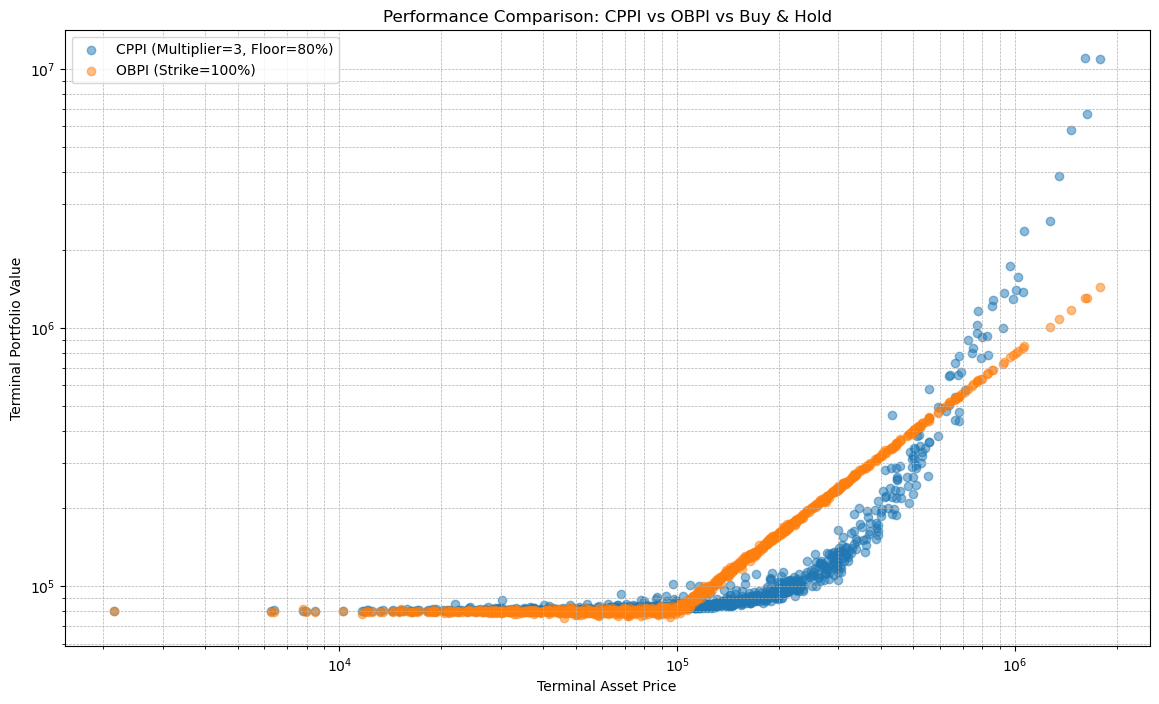

In [101]:
plt.figure(figsize=(14, 8))

# CPPI Outcomes 
plt.scatter(terminal_prices, terminal_cppi, 
            alpha=0.5, 
            label='CPPI (Multiplier=3, Floor=80%)')

# OBPI Outcomes 
plt.scatter(terminal_prices, terminal_obpi, 
            alpha=0.5, 
            label='OBPI (Strike=100%)')

plt.title('Performance Comparison: CPPI vs OBPI vs Buy & Hold')
plt.xlabel('Terminal Asset Price')
plt.xscale('log')  # Use log scale for better visualization
plt.ylabel('Terminal Portfolio Value')
plt.yscale('log')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [102]:
# Extract rebalancing frequencies
volatilities_cppi = list(results_cppi["Average Returns"].keys())
volatilities_obpi = list(results_obpi["Average Returns"].keys())

# Get the values for average returns, volatility, and Sharpe ratios
avg_returns_cppi = [results_cppi["Average Returns"][f] for f in volatilities_cppi]
volatility_cppi = [results_cppi["Volatility"][f] for f in volatilities_cppi]
sharpe_cppi = [results_cppi["Sharpe Ratios"][f] for f in volatilities_cppi]

avg_returns_obpi = [results_obpi["Average Returns"][f] for f in volatilities_obpi]
volatility_obpi = [results_obpi["Volatility"][f] for f in volatilities_obpi]
sharpe_obpi = [results_obpi["Sharpe Ratios"][f] for f in volatilities_obpi]

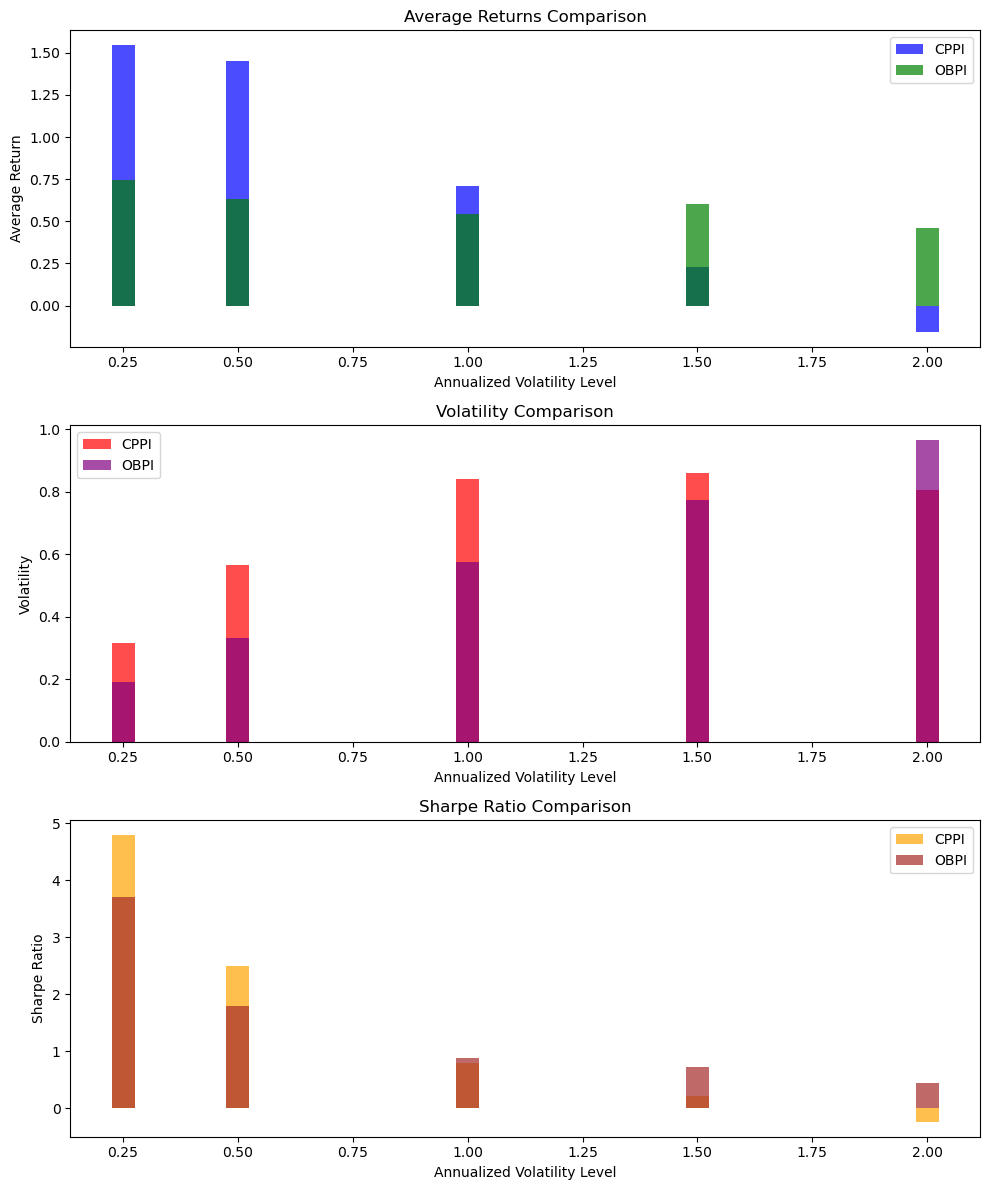

In [103]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# Bar chart for Average Returns
axes[0].bar(volatilities_cppi, avg_returns_cppi, width=0.05, label='CPPI', alpha=0.7, color='blue')
axes[0].bar(volatilities_obpi, avg_returns_obpi, width=0.05, label='OBPI', alpha=0.7, color='green')
axes[0].set_title('Average Returns Comparison')
axes[0].set_xlabel('Annualized Volatility Level')
axes[0].set_ylabel('Average Return')
axes[0].legend()

# Bar chart for Volatility
axes[1].bar(volatilities_cppi, volatility_cppi, width=0.05, label='CPPI', alpha=0.7, color='red')
axes[1].bar(volatilities_obpi, volatility_obpi, width=0.05, label='OBPI', alpha=0.7, color='purple')
axes[1].set_title('Volatility Comparison')
axes[1].set_xlabel('Annualized Volatility Level')
axes[1].set_ylabel('Volatility')
axes[1].legend()

# Bar chart for Sharpe Ratios
axes[2].bar(volatilities_cppi, sharpe_cppi, width=0.05, label='CPPI', alpha=0.7, color='orange')
axes[2].bar(volatilities_obpi, sharpe_obpi, width=0.05, label='OBPI', alpha=0.7, color='brown')
axes[2].set_title('Sharpe Ratio Comparison')
axes[2].set_xlabel('Annualized Volatility Level')
axes[2].set_ylabel('Sharpe Ratio')
axes[2].legend()

plt.tight_layout()
plt.show()

### Impact of Floor level

In [104]:
time_to_maturity = len(price_paths) / 365

cppi_results_robustness_floor = cppi_strategy(price_paths, 0.04, [3], floor_fractions, initial_portfolio_value)
obpi_results_robustness_floor = obpi_strategy(price_paths, 0.04, floor_fractions, initial_portfolio_value, time_to_maturity, historical_volatility.iloc[0])

#### CPPI

In [105]:
def compute_metrics_cppi_floor(cppi_results, m=3, riskless_rate=0.04):
    """
    Computes the average return, volatility, and Sharpe ratio for each floor fraction
    for a specific multiplier in the CPPI strategy.

    Parameters:
        cppi_results (dict): Output from the cppi_strategy_robustness_rebalancing function.
                             Expected keys: (m, floor).
        m (int or float): The multiplier (e.g., 3).
        riskless_rate (float): The annual risk-free rate (e.g., 0.04 for 4%).

    Returns:
        dict: A dictionary containing average returns, volatility, and Sharpe ratios for each floor fraction.
    """
    avg_returns = {}
    volatility = {}
    sharpe_ratios = {}

    # Loop through (m, floor) keys in the dictionary
    for (multiplier, floor), results in cppi_results.items():
        # Process only the specified multiplier
        if multiplier == m:
            # Extract basket values (portfolio values over time)
            basket_values = results['Basket Values']

            # Ensure basket_values has the expected shape (n_steps, n_simulations)
            if basket_values.ndim != 2:
                raise ValueError("Basket values must be a 2D array (n_steps, n_simulations)")

            # Compute returns across time (percentage change)
            basket_values_ret = basket_values[1:] / basket_values[:-1] - 1  # (n_steps - 1, n_simulations)

            # Compute the final and initial values for each simulation
            final_values = basket_values[-1, :]  # Final value for each simulation
            initial_values = basket_values[0, :]  # Initial value for each simulation

            # Compute cumulative returns for each simulation
            returns = (final_values - initial_values) / initial_values

            # Calculate average return across simulations
            avg_returns[floor] = np.mean(returns)

            # Calculate volatility (Annualized standard deviation of returns)
            # - Standard deviation across simulations at each time step
            # - Mean of these volatilities across time
            volatility[floor] = np.mean(np.std(basket_values_ret, axis=1)) * np.sqrt(365)

            # Calculate Sharpe ratio: (Excess return) / Volatility
            sharpe_ratios[floor] = (
                (avg_returns[floor] - riskless_rate) / volatility[floor]
                if volatility[floor] > 0 else np.nan
            )

    # Return the computed metrics
    return {
        "Average Returns": avg_returns,
        "Volatility": volatility,
        "Sharpe Ratios": sharpe_ratios
    }

In [106]:
# Compute average returns for each rebalancing frequency
results_cppi = compute_metrics_cppi_floor(cppi_results_robustness_floor)

# Print the results_cppi
print("Average Returns:", results_cppi["Average Returns"])
print("Volatility:", results_cppi["Volatility"])
print("Sharpe Ratios:", results_cppi["Sharpe Ratios"])

Average Returns: {0.5: 3.8238554657404733, 0.6: 3.0899556676957913, 0.7: 2.3560558696511094, 0.8: 1.6221560716064278, 0.9: 0.8882562735617439, 1: 0.15435647551705944}
Volatility: {0.5: 1.1902388332503393, 0.6: 1.053128826276044, 0.7: 0.9056987727759469, 0.8: 0.7365664365845157, 0.9: 0.5197013930131559, 1: 0.11911946212336522}
Sharpe Ratios: {0.5: 3.1790724349056982, 0.6: 2.8960898150330783, 0.7: 2.5572032769266637, 0.8: 2.1480154308183534, 0.9: 1.632199345558173, 1: 0.9600150427024844}


#### OBPI

In [107]:
def compute_metrics_obpi_floor(results, riskless_rate=0.04):
    """
    Computes the average return, volatility, and Sharpe ratio for each floor fraction
    in the OBPI strategy.

    Parameters:
        results (dict): Output from the OBPI strategy function.
                        Expected keys: floor fractions (e.g., 0.5, 0.6, ...).
        riskless_rate (float): The annual risk-free rate (e.g., 0.04 for 4%).

    Returns:
        dict: A dictionary containing average returns, volatility, and Sharpe ratios for each floor fraction.
    """
    avg_returns = {}
    volatilities = {}
    sharpe_ratios = {}

    # Loop through each floor fraction
    for floor, result in results.items():
        # Extract basket values
        basket_values = result['Basket Values']

        # Ensure basket_values has the expected shape (n_steps, n_simulations)
        if basket_values.ndim != 2:
            raise ValueError("Basket values must be a 2D array (n_steps, n_simulations)")

        # Compute percentage returns across time steps
        basket_values_ret = basket_values[1:] / basket_values[:-1] - 1  # (n_steps - 1, n_simulations)

        # Compute final and initial values for each simulation
        final_values = basket_values[-1, :]
        initial_values = basket_values[0, :]

        # Compute cumulative returns for each simulation
        returns = (final_values - initial_values) / initial_values

        # Calculate average return across simulations
        avg_returns[floor] = np.mean(returns)

        # Calculate volatility (Annualized standard deviation of returns)
        volatilities[floor] = np.mean(np.std(basket_values_ret, axis=1)) * np.sqrt(365)

        # Calculate Sharpe ratio: (Excess return) / Volatility
        sharpe_ratios[floor] = (
            (avg_returns[floor] - riskless_rate) / volatilities[floor]
            if volatilities[floor] > 0 else np.nan
        )

    # Return the computed metrics
    return {
        "Average Returns": avg_returns,
        "Volatility": volatilities,
        "Sharpe Ratios": sharpe_ratios
    }

In [108]:
# Compute average returns for each rebalancing frequency
results_obpi = compute_metrics_obpi_floor(obpi_results_robustness_floor)

# Print the results_cppi
print("Average Returns:", results_obpi["Average Returns"])
print("Volatility:", results_obpi["Volatility"])
print("Sharpe Ratios:", results_obpi["Sharpe Ratios"])

Average Returns: {0.5: 1.0460114096339261, 0.6: 0.9767768975682898, 0.7: 0.8990493561481058, 0.8: 0.819166924850097, 0.9: 0.7405378864061816, 1: 0.6661754601557065}
Volatility: {0.5: 0.6250065204877717, 0.6: 0.5889460180532898, 0.7: 0.5508276295120055, 0.8: 0.5126633963816553, 0.9: 0.4757158708721219, 1: 0.4407944049696463}
Sharpe Ratios: {0.5: 1.609601462795633, 0.6: 1.5905989154400344, 0.7: 1.5595611224316452, 0.8: 1.5198411479138285, 0.9: 1.4725972566815928, 1: 1.4205612709599291}


#### Analysis

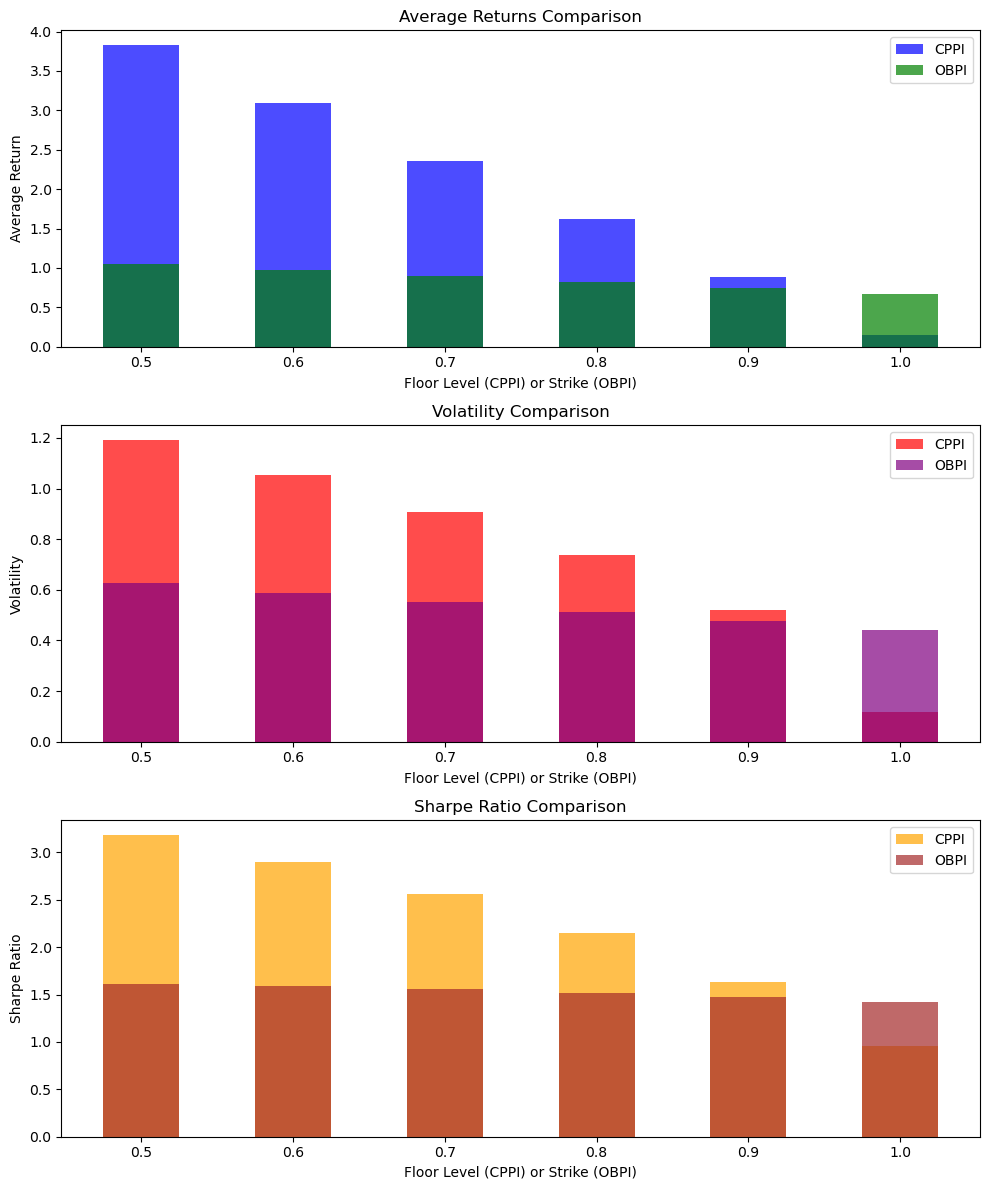

In [109]:
# Extract rebalancing frequencies
floors_cppi = list(results_cppi["Average Returns"].keys())
floors_obpi = list(results_obpi["Average Returns"].keys())

# Get the values for average returns, volatility, and Sharpe ratios
avg_returns_cppi = [results_cppi["Average Returns"][f] for f in floors_cppi]
volatility_cppi = [results_cppi["Volatility"][f] for f in floors_cppi]
sharpe_cppi = [results_cppi["Sharpe Ratios"][f] for f in floors_cppi]

avg_returns_obpi = [results_obpi["Average Returns"][f] for f in floors_obpi]
volatility_obpi = [results_obpi["Volatility"][f] for f in floors_obpi]
sharpe_obpi = [results_obpi["Sharpe Ratios"][f] for f in floors_obpi]

# Create subplots: 3 rows for Average Return, Volatility, and Sharpe Ratio
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# Bar chart for Average Returns
axes[0].bar(floors_cppi, avg_returns_cppi, width=0.05, label='CPPI', alpha=0.7, color='blue')
axes[0].bar(floors_obpi, avg_returns_obpi, width=0.05, label='OBPI', alpha=0.7, color='green')
axes[0].set_title('Average Returns Comparison')
axes[0].set_xlabel('Floor Level (CPPI) or Strike (OBPI)')
axes[0].set_ylabel('Average Return')
axes[0].legend()

# Bar chart for Volatility
axes[1].bar(floors_cppi, volatility_cppi, width=0.05, label='CPPI', alpha=0.7, color='red')
axes[1].bar(floors_obpi, volatility_obpi, width=0.05, label='OBPI', alpha=0.7, color='purple')
axes[1].set_title('Volatility Comparison')
axes[1].set_xlabel('Floor Level (CPPI) or Strike (OBPI)')
axes[1].set_ylabel('Volatility')
axes[1].legend()

# Bar chart for Sharpe Ratios
axes[2].bar(floors_cppi, sharpe_cppi, width=0.05, label='CPPI', alpha=0.7, color='orange')
axes[2].bar(floors_obpi, sharpe_obpi, width=0.05, label='OBPI', alpha=0.7, color='brown')
axes[2].set_title('Sharpe Ratio Comparison')
axes[2].set_xlabel('Floor Level (CPPI) or Strike (OBPI)')
axes[2].set_ylabel('Sharpe Ratio')
axes[2].legend()

plt.tight_layout()
plt.show()

### Impact of multiplier (CPPI)

In [110]:
cppi_results_robustness_multiplier = cppi_strategy(price_paths, 0.04, multipliers, [0.8], initial_portfolio_value)

In [111]:
def compute_metrics_cppi_multiplier(cppi_results, f=0.8, riskless_rate=0.04):
    """
    Computes the average return, volatility, and Sharpe ratio for each floor fraction
    for a specific multiplier in the CPPI strategy.

    Parameters:
        cppi_results (dict): Output from the cppi_strategy_robustness_rebalancing function.
                             Expected keys: (m, floor).
        m (int or float): The multiplier (e.g., 3).
        riskless_rate (float): The annual risk-free rate (e.g., 0.04 for 4%).

    Returns:
        dict: A dictionary containing average returns, volatility, and Sharpe ratios for each floor fraction.
    """
    avg_returns = {}
    volatility = {}
    sharpe_ratios = {}

    # Loop through (m, floor) keys in the dictionary
    for (multiplier, floor), results in cppi_results.items():
        # Process only the specified multiplier
        if floor == f:
            # Extract basket values (portfolio values over time)
            basket_values = results['Basket Values']

            # Ensure basket_values has the expected shape (n_steps, n_simulations)
            if basket_values.ndim != 2:
                raise ValueError("Basket values must be a 2D array (n_steps, n_simulations)")

            # Compute returns across time (percentage change)
            basket_values_ret = basket_values[1:] / basket_values[:-1] - 1  # (n_steps - 1, n_simulations)

            # Compute the final and initial values for each simulation
            final_values = basket_values[-1, :]  # Final value for each simulation
            initial_values = basket_values[0, :]  # Initial value for each simulation

            # Compute cumulative returns for each simulation
            returns = (final_values - initial_values) / initial_values

            # Calculate average return across simulations
            avg_returns[multiplier] = np.mean(returns)

            # Calculate volatility (Annualized standard deviation of returns)
            # - Standard deviation across simulations at each time step
            # - Mean of these volatilities across time
            volatility[multiplier] = np.mean(np.std(basket_values_ret, axis=1)) * np.sqrt(365)

            # Calculate Sharpe ratio: (Excess return) / Volatility
            sharpe_ratios[multiplier] = (
                (avg_returns[multiplier] - riskless_rate) / volatility[multiplier]
                if volatility[multiplier] > 0 else np.nan
            )

    # Return the computed metrics
    return {
        "Average Returns": avg_returns,
        "Volatility": volatility,
        "Sharpe Ratios": sharpe_ratios
    }

In [112]:
# Compute average returns for each rebalancing frequency
results_cppi = compute_metrics_cppi_multiplier(cppi_results_robustness_multiplier)

# Print the results_cppi
print("Average Returns:", results_cppi["Average Returns"])
print("Volatility:", results_cppi["Volatility"])
print("Sharpe Ratios:", results_cppi["Sharpe Ratios"])

Average Returns: {1: 0.27896820071484363, 2: 0.7500517537737414, 3: 1.6221560716064278, 4: 2.948206103227876, 5: 4.194850390364125, 6: 4.291562135537323}
Volatility: {1: 0.19693741910601725, 2: 0.4658605334940206, 3: 0.7365664365845157, 4: 0.9602360724765021, 5: 1.1140963584507215, 6: 1.1927846295478168}
Sharpe Ratios: {1: 1.2134220190333658, 2: 1.5241723707484978, 3: 2.1480154308183534, 4: 3.0286365890498685, 5: 3.729345634108274, 6: 3.564400504682127}


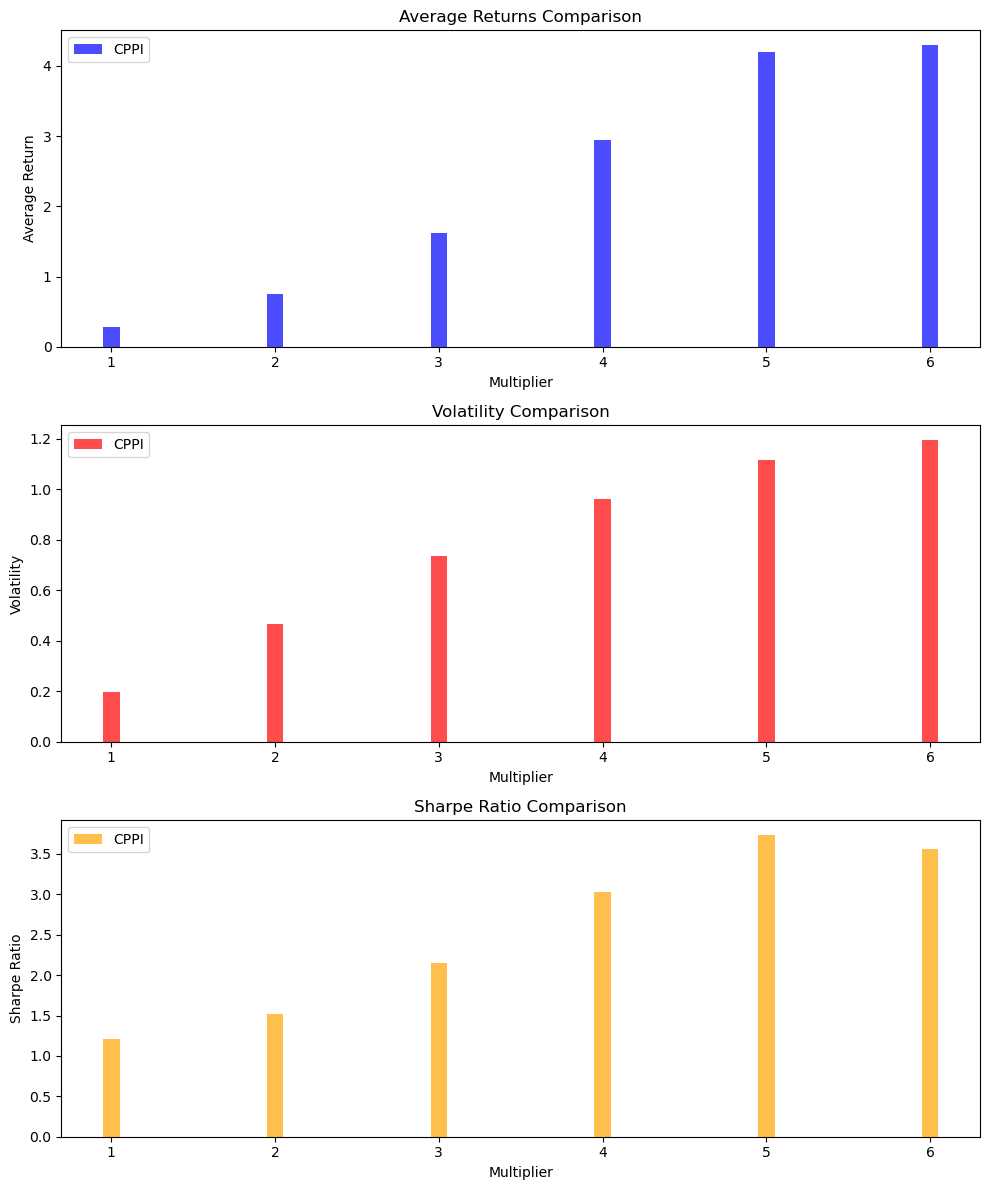

In [113]:
# Extract rebalancing frequencies
multipliers_cppi = list(results_cppi["Average Returns"].keys())

# Get the values for average returns, volatility, and Sharpe ratios
avg_returns_cppi = [results_cppi["Average Returns"][f] for f in multipliers_cppi]
volatility_cppi = [results_cppi["Volatility"][f] for f in multipliers_cppi]
sharpe_cppi = [results_cppi["Sharpe Ratios"][f] for f in multipliers_cppi]

# Create subplots: 3 rows for Average Return, Volatility, and Sharpe Ratio
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# Bar chart for Average Returns
axes[0].bar(multipliers_cppi, avg_returns_cppi, width=0.1, label='CPPI', alpha=0.7, color='blue')
axes[0].set_title('Average Returns Comparison')
axes[0].set_xlabel('Multiplier')
axes[0].set_ylabel('Average Return')
axes[0].legend()

# Bar chart for Volatility
axes[1].bar(multipliers_cppi, volatility_cppi, width=0.1, label='CPPI', alpha=0.7, color='red')
axes[1].set_title('Volatility Comparison')
axes[1].set_xlabel('Multiplier')
axes[1].set_ylabel('Volatility')
axes[1].legend()

# Bar chart for Sharpe Ratios
axes[2].bar(multipliers_cppi, sharpe_cppi, width=0.1, label='CPPI', alpha=0.7, color='orange')
axes[2].set_title('Sharpe Ratio Comparison')
axes[2].set_xlabel('Multiplier')
axes[2].set_ylabel('Sharpe Ratio')
axes[2].legend()

plt.tight_layout()
plt.show()

## Extensions to conventional Portfolio Insurance strategies

CPPI extension: Maximum Drawdown (Dynamic Floor)  
OBPI extension: Move Based Rebalancing or Leveraged OBPI

### Maximum Drawdown CPPI

In [114]:
def cppi_mdd_strategy(risky_asset, riskless_rate, multipliers, floor_fractions, initial_portfolio_value):
    """
    Implements a CPPI (Constant Proportion Portfolio Insurance) strategy with a dynamically 
    updated floor based on Maximum Drawdown (MDD).

    Parameters:
        risky_asset (ndarray): Prices of the risky asset (e.g., BTC), shape (n_steps, n_simulations).
        riskless_rate (float): The constant annual risk-free rate (e.g., 0.02 for 2%).
        multipliers (array-like): Array of multipliers for the cushion.
        floor_fractions (array-like): Array of floor fractions of the peak portfolio value.
        initial_portfolio_value (float): Initial value of the portfolio.

    Returns:
        dict: A dictionary containing results for each (multiplier, floor_fraction) combination.
    """

    n_steps, n_simulations = risky_asset.shape
    riskless_return = (1 + riskless_rate) ** (1 / 365) - 1

    results = {}

    for multiplier in multipliers:
        for floor_fraction in floor_fractions:
            # Initialize arrays
            basket_values = np.zeros((n_steps, n_simulations))
            risky_weights = np.zeros((n_steps, n_simulations))
            riskless_weights = np.zeros((n_steps, n_simulations))
            peak_values = np.zeros((n_steps, n_simulations))  # Track the highest portfolio value
            drawdowns = np.zeros((n_steps, n_simulations))  # Track drawdowns

            # Initial conditions
            basket_values[0] = initial_portfolio_value
            peak_values[0] = initial_portfolio_value
            floor = peak_values[0] * floor_fraction  # Dynamic floor based on peak value

            # Compute the initial cushion
            initial_cushion = np.maximum(basket_values[0] - floor, 0) / basket_values[0]
            risky_weights[0] = np.maximum(multiplier * initial_cushion, 0)
            riskless_weights[0] = 1 - risky_weights[0]

            # CPPI dynamics for each time step
            for t in range(1, n_steps):
                # Compute risky returns
                risky_returns = (risky_asset[t] - risky_asset[t - 1]) / risky_asset[t - 1]

                # Portfolio return: combine risky and riskless returns
                port_returns = (risky_weights[t-1] * risky_returns + 
                               riskless_weights[t-1] * riskless_return)
                
                # Update portfolio value
                basket_values[t] = basket_values[t-1] * (1 + port_returns)

                # Update peak value and floor dynamically
                peak_values[t] = np.maximum(peak_values[t-1], basket_values[t])
                floor = peak_values[t] * floor_fraction  # Dynamic floor based on max observed value

                # Compute Maximum Drawdown (MDD)
                drawdowns[t] = (peak_values[t] - basket_values[t]) / peak_values[t]

                # Update weights
                cushion = np.maximum(basket_values[t] - floor, 0) / basket_values[t]
                risky_weights[t] = np.maximum(multiplier * cushion, 0)
                riskless_weights[t] = 1 - risky_weights[t]

            # Store the results for the current multiplier and floor_fraction
            results[(multiplier, floor_fraction)] = {
                'Basket Values': basket_values,
                'Risky Weights': risky_weights,
                'Riskless Weights': riskless_weights,
                'Peak Values': peak_values,
                'Drawdowns': drawdowns,  # Track the Maximum Drawdown over time
            }

    return results

In [115]:
cppi_results_mdd = cppi_mdd_strategy(price_paths, 0.04, multipliers, floor_fractions, initial_portfolio_value)

In [116]:
multiplier = 3
floor_frac = 0.8
key = (multiplier, floor_frac)

terminal_prices = price_paths[-1]  # Last row of price simulations
terminal_cppi = cppi_results[key]['Basket Values'][-1]  # Last row of CPPI basket values
terminal_cppi_mdd = cppi_results_mdd[key]['Basket Values'][-1]  # Last row of MDD CPPI basket values

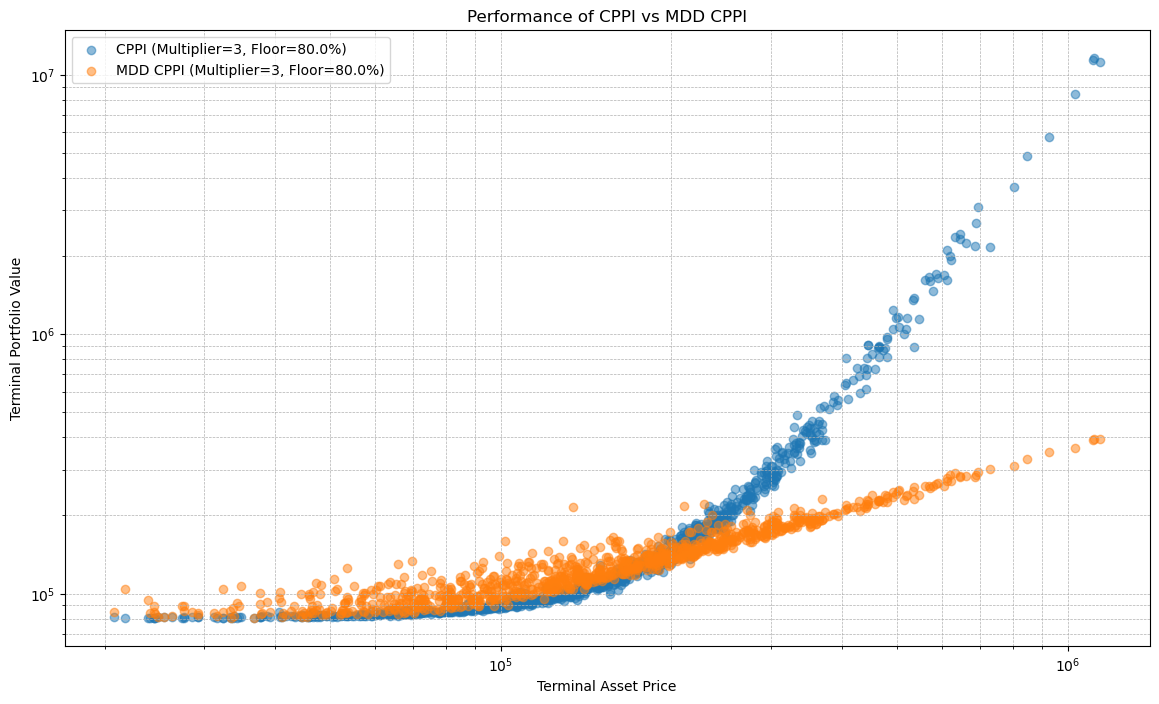

In [117]:
plt.figure(figsize=(14, 8))

# CPPI Outcomes 
plt.scatter(terminal_prices, terminal_cppi, 
            alpha=0.5, 
            label=f'CPPI (Multiplier={multiplier}, Floor={floor_frac*100}%)')

# MDD CPPI Outcomes 
plt.scatter(terminal_prices, terminal_cppi_mdd, 
            alpha=0.5, 
            label=f'MDD CPPI (Multiplier={multiplier}, Floor={floor_frac*100}%)')

plt.title('Performance of CPPI vs MDD CPPI')
plt.xlabel('Terminal Asset Price')
plt.xscale('log')  # Use log scale for better visualization
plt.ylabel('Terminal Portfolio Value')
plt.yscale('log')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [118]:
benchmark_prices = price_paths

# MDD CPPI Strategy Performance
cppi_strategy_results_mdd = cppi_results_mdd[(3, 0.8)]
cppi_portfolio_values_mdd = np.array(cppi_strategy_results_mdd['Basket Values'])
cppi_metrics_mdd = performance(cppi_portfolio_values_mdd, benchmark_prices)
cppi_turnover_mdd = turnover(cppi_strategy_results_mdd['Risky Weights'])

# CPPI Strategy Performance
cppi_strategy_results = cppi_results[(3, 0.8)]
cppi_portfolio_values = np.array(cppi_strategy_results['Basket Values'])
cppi_metrics = performance(cppi_portfolio_values, benchmark_prices)
cppi_turnover = turnover(cppi_strategy_results['Risky Weights'])

# Display Results
def print_metrics(name, metrics, turnover):
    print(f"{name} Strategy Metrics:")
    for metric, value in metrics.items():
        print(f"{metric.replace('_', ' ').title()}: {value:.4f}")
    print(f"Turnover: {turnover:.2f}%\n")

print_metrics("MDD CPPI", cppi_metrics_mdd, cppi_turnover_mdd)
print_metrics("CPPI", cppi_metrics, cppi_turnover)

MDD CPPI Strategy Metrics:
Annualized Return: 0.3510
Annualized Volatility: 0.2546
Sharpe Ratio: 1.1069
Sortino Ratio: 2.0748
Var 5: -0.0207
Es 5: -0.0286
Skewness: 0.0935
Kurtosis: 5.6420
Max Drawdown: -0.1703
Information Ratio: -1.1597
Turnover: 822.89%

CPPI Strategy Metrics:
Annualized Return: 1.6082
Annualized Volatility: 0.6419
Sharpe Ratio: 1.1604
Sortino Ratio: 2.2663
Var 5: -0.0530
Es 5: -0.0737
Skewness: -0.0795
Kurtosis: 5.7962
Max Drawdown: -0.4249
Information Ratio: -0.5981
Turnover: 1447.82%



In [119]:
print('BTC metrics:')
compute_btc_metrics(price_paths)

BTC metrics:


{'Annualized Return': '174.34%',
 'Annualized Volatility': '69.53%',
 'Sharpe Ratio': '2.51',
 'Sortino Ratio': '4.47',
 'VaR (5%)': '-5.62%',
 'Expected Shortfall (5%)': '-6.98%',
 'Skewness': '0.11',
 'Kurtosis': '0.00',
 'Max Drawdown': '-45.60%'}

### Leveraged OBPI

In [120]:
def obpi_strategy_leveraged(risky_asset, riskless_rate, floor_fractions, initial_portfolio_value, time_to_maturity, sigma, leverage_factor):
    """
    Implements a Leveraged OBPI (Option-Based Portfolio Insurance) strategy for multiple floor fractions.

    Parameters:
        risky_asset (ndarray): Simulated risky asset prices, shape (n_steps, n_simulations).
        riskless_rate (float): Annualized risk-free rate (e.g., 0.02 for 2%).
        floor_fractions (list): List of floor fractions to test.
        initial_portfolio_value (float): Initial value of the portfolio.
        time_to_maturity (float): Time to maturity in years.
        sigma (float or ndarray): Volatility of the risky asset (annualized), 
                                  either a float (constant) or ndarray (n_steps, n_simulations).
        leverage_factor (float): Factor by which the risky asset allocation can be increased (e.g., 1.5 means up to 150%).

    Returns:
        dict: Dictionary containing results for each floor fraction.
    """
    n_steps, n_simulations = risky_asset.shape
    steps_per_year = 365  # adjust for daily rebalancing
    riskless_return = (1 + riskless_rate) ** (1 / steps_per_year) - 1
    dt = 1 / steps_per_year  
    results = {}

    def black_scholes_put(S, K, T, r, sigma):
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        put_delta = -norm.cdf(-d1)
        return put_price, put_delta

    if np.isscalar(sigma):
        sigma = np.full((n_steps, n_simulations), sigma)

    if sigma.shape != (n_steps, n_simulations):
        raise ValueError("sigma must be either a scalar or have shape (n_steps, n_simulations)")

    for floor_fraction in floor_fractions:
        # Initialize arrays
        basket_values = np.zeros((n_steps, n_simulations))
        risky_weights = np.zeros((n_steps, n_simulations))
        riskless_weights = np.zeros((n_steps, n_simulations))
        put_prices = np.zeros((n_steps, n_simulations))
        put_deltas = np.zeros((n_steps, n_simulations))

        # Initial floor
        floor = initial_portfolio_value * floor_fraction

        # Compute initial put price and delta for all simulations
        initial_put_price, initial_put_delta = black_scholes_put(
            risky_asset[0], floor, time_to_maturity, riskless_rate, sigma[0]
        )

        # Compute initial weights with leverage
        risky_w = leverage_factor * ((1 + initial_put_delta) * risky_asset[0]) / (risky_asset[0] + initial_put_price)
        riskless_w = 1 - risky_w  

        # Allow negative riskless weights (borrowing)
        risky_w = np.maximum(0, risky_w)
        riskless_w = np.minimum(1, riskless_w)  # Ensuring total exposure remains reasonable

        # Set initial values
        basket_values[0, :] = initial_portfolio_value
        risky_weights[0, :] = risky_w
        riskless_weights[0, :] = riskless_w
        put_prices[0, :] = initial_put_price
        put_deltas[0, :] = initial_put_delta

        # Loop over time steps
        for i in range(1, n_steps):
            remaining_ttm = time_to_maturity - i * dt  

            # Compute returns
            risky_return = (risky_asset[i] - risky_asset[i - 1]) / risky_asset[i - 1]

            # Update portfolio value
            portfolio_return = (risky_weights[i - 1] * risky_return +
                                riskless_weights[i - 1] * riskless_return)
            basket_values[i] = basket_values[i - 1] * (1 + portfolio_return)

            # Compute new put option price and delta 
            put_price, put_delta = black_scholes_put(
                risky_asset[i], floor, remaining_ttm, riskless_rate, sigma[i]
            )

            # Update weights with leverage
            risky_w = leverage_factor * ((1 + put_delta) * risky_asset[i]) / (risky_asset[i] + put_price)
            riskless_w = 1 - risky_w  

            # Allow for leverage (negative riskless weight = borrowing)
            risky_w = np.maximum(0, risky_w)
            riskless_w = np.minimum(1, riskless_w)  

            # Store values
            risky_weights[i] = risky_w
            riskless_weights[i] = riskless_w
            put_prices[i] = put_price
            put_deltas[i] = put_delta

        # Store results
        results[floor_fraction] = {
            "Basket Values": basket_values,
            "Risky Weights": risky_weights,
            "Riskless Weights": riskless_weights,
            "Put Price": put_prices,
            "Put Delta": put_deltas,
        }

    return results

In [121]:
time_to_maturity = len(price_paths)/365  # adjust (52 for weekly, 365 for daily)
leverage_factor = 1.5

obpi_results_leveraged = obpi_strategy_leveraged(price_paths, 0.04, floor_fractions, initial_portfolio_value, time_to_maturity, historical_volatility.iloc[0], leverage_factor)

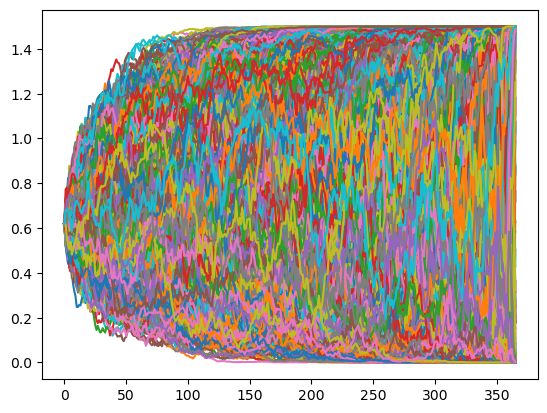

In [122]:
plt.plot(obpi_results_leveraged[1]['Risky Weights'])
plt.show()

In [123]:
floor_frac = 1
key = (floor_frac)

terminal_prices = price_paths[-1]  # Last row of price simulations
terminal_obpi = obpi_results[key]['Basket Values'][-1]  # Last row of OBPI basket values
terminal_obpi_leveraged = obpi_results_leveraged[key]['Basket Values'][-1]  # Last row of leveraged OBPI basket values

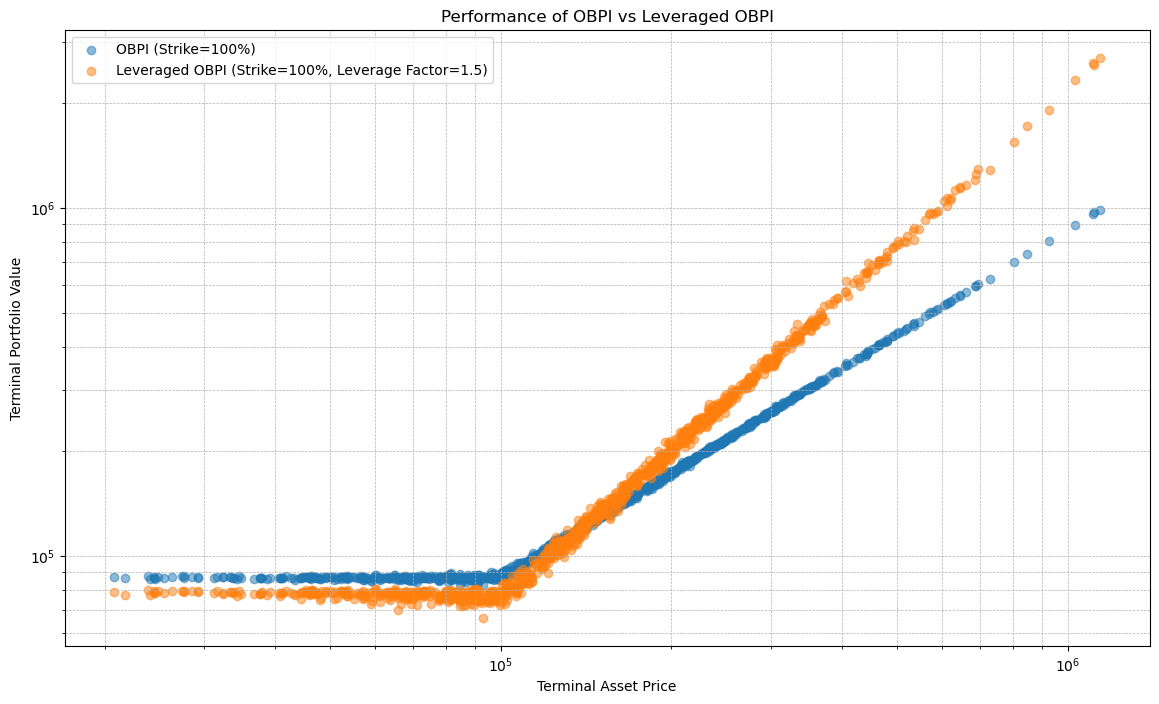

In [124]:
plt.figure(figsize=(14, 8))

# OBPI Outcomes 
plt.scatter(terminal_prices, terminal_obpi, 
            alpha=0.5, 
            label=f'OBPI (Strike={floor_frac*100}%)')

# Leveraged OBPI Outcomes 
plt.scatter(terminal_prices, terminal_obpi_leveraged, 
            alpha=0.5, 
            label=f'Leveraged OBPI (Strike={floor_frac*100}%, Leverage Factor={leverage_factor})')

plt.title('Performance of OBPI vs Leveraged OBPI')
plt.xlabel('Terminal Asset Price')
plt.xscale('log')  # Use log scale for better visualization
plt.ylabel('Terminal Portfolio Value')
plt.yscale('log')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [125]:
benchmark_prices = price_paths

# Leveraged OBPI Strategy Performance
obpi_strategy_results_leveraged = obpi_results_leveraged[(1)]
obpi_portfolio_values_leveraged = np.array(obpi_strategy_results_leveraged['Basket Values'])
obpi_metrics_leveraged = performance(obpi_portfolio_values_leveraged, benchmark_prices)
obpi_turnover_leveraged = turnover(obpi_strategy_results_leveraged['Risky Weights'])

# OBPI Strategy Performance
obpi_strategy_results = obpi_results[(1)]
obpi_portfolio_values = np.array(obpi_strategy_results['Basket Values'])
obpi_metrics = performance(obpi_portfolio_values, benchmark_prices)
obpi_turnover = turnover(obpi_strategy_results['Risky Weights'])

# Display Results
def print_metrics(name, metrics, turnover):
    print(f"{name} Strategy Metrics:")
    for metric, value in metrics.items():
        print(f"{metric.replace('_', ' ').title()}: {value:.4f}")
    print(f"Turnover: {turnover:.2f}%\n")

print_metrics("Leveraged OBPI", obpi_metrics_leveraged, obpi_turnover_leveraged)
print_metrics("OBPI", obpi_metrics, obpi_turnover)

Leveraged OBPI Strategy Metrics:
Annualized Return: 1.1727
Annualized Volatility: 0.6261
Sharpe Ratio: 1.2444
Sortino Ratio: 2.4240
Var 5: -0.0516
Es 5: -0.0690
Skewness: 0.0056
Kurtosis: 5.0756
Max Drawdown: -0.4226
Information Ratio: -0.3946
Turnover: 920.85%

OBPI Strategy Metrics:
Annualized Return: 0.6631
Annualized Volatility: 0.4174
Sharpe Ratio: 1.0638
Sortino Ratio: 2.0537
Var 5: -0.0344
Es 5: -0.0460
Skewness: 0.0056
Kurtosis: 5.0756
Max Drawdown: -0.2993
Information Ratio: -1.2825
Turnover: 613.90%



In [126]:
print('BTC metrics:')
compute_btc_metrics(price_paths)

BTC metrics:


{'Annualized Return': '174.34%',
 'Annualized Volatility': '69.53%',
 'Sharpe Ratio': '2.51',
 'Sortino Ratio': '4.47',
 'VaR (5%)': '-5.62%',
 'Expected Shortfall (5%)': '-6.98%',
 'Skewness': '0.11',
 'Kurtosis': '0.00',
 'Max Drawdown': '-45.60%'}

#### Comparison of both extensions

In [127]:
terminal_bnh = bnh_results['Basket Values'][-1]  # Last row of B&H basket values

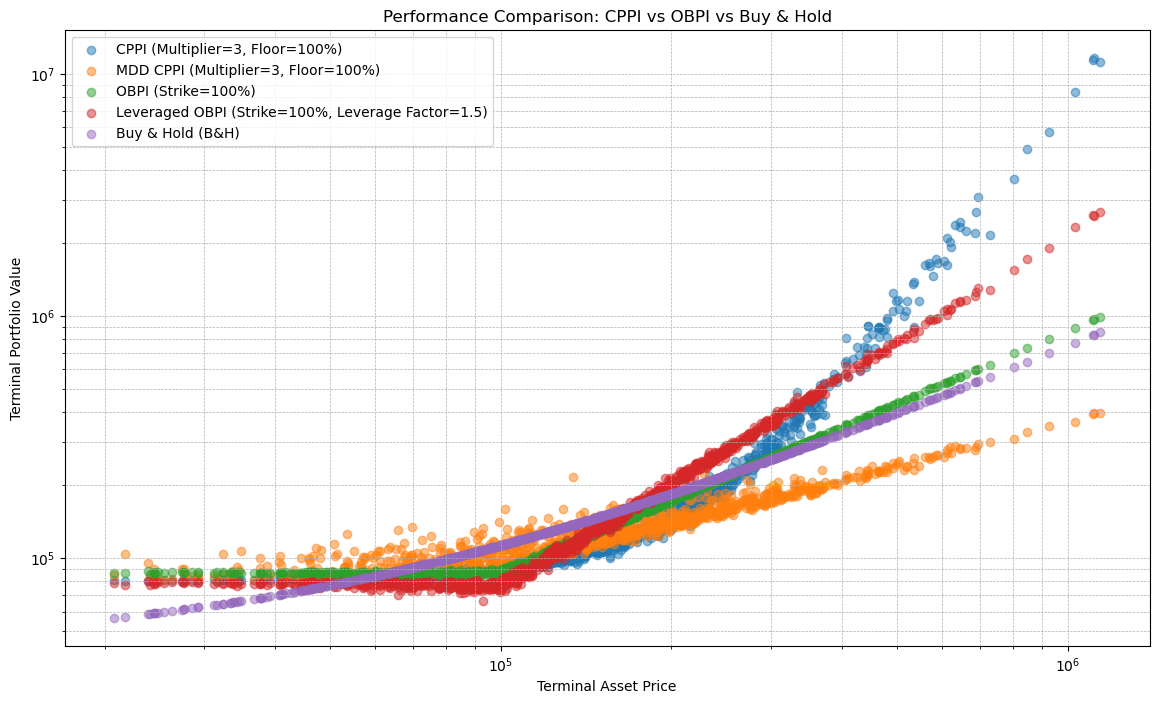

In [128]:
plt.figure(figsize=(14, 8))

# CPPI Outcomes 
plt.scatter(terminal_prices, terminal_cppi, 
            alpha=0.5, 
            label=f'CPPI (Multiplier={multiplier}, Floor={floor_frac*100}%)')

# MDD CPPI Outcomes 
plt.scatter(terminal_prices, terminal_cppi_mdd, 
            alpha=0.5, 
            label=f'MDD CPPI (Multiplier={multiplier}, Floor={floor_frac*100}%)')

# OBPI Outcomes 
plt.scatter(terminal_prices, terminal_obpi, 
            alpha=0.5, 
            label=f'OBPI (Strike={floor_frac*100}%)')

# Leveraged OBPI Outcomes 
plt.scatter(terminal_prices, terminal_obpi_leveraged, 
            alpha=0.5, 
            label=f'Leveraged OBPI (Strike={floor_frac*100}%, Leverage Factor={leverage_factor})')

# Buy & Hold Outcomes
plt.scatter(terminal_prices, terminal_bnh, 
            alpha=0.5, 
            label='Buy & Hold (B&H)')

plt.title('Performance Comparison: CPPI vs OBPI vs Buy & Hold')
plt.xlabel('Terminal Asset Price')
plt.xscale('log')  # Use log scale for better visualization
plt.ylabel('Terminal Portfolio Value')
plt.yscale('log')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

#### Move-based rebalancing CPPI and OBPI

In [129]:
def cppi_strategy_move_based_rebalancing(risky_asset, riskless_rate, multipliers, floor_fractions, initial_portfolio_value, move_threshold):
    """
    Implements the CPPI (Constant Proportion Portfolio Insurance) strategy with move-based rebalancing.

    Parameters:
        risky_asset (ndarray): Prices of the risky asset, shape (n_steps, n_simulations).
        riskless_rate (float): Annualized risk-free rate (e.g., 0.02 for 2%).
        multipliers (array-like): List of multipliers for the cushion.
        floor_fractions (array-like): List of floor fractions of the initial portfolio value.
        initial_portfolio_value (float): Initial value of the portfolio.
        move_threshold (float): Percentage change in risky asset price that triggers rebalancing (e.g., 0.05 for ±5%).

    Returns:
        dict: A dictionary containing results for each (multiplier, floor_fraction) combination.
    """

    n_steps, n_simulations = risky_asset.shape
    riskless_return = (1 + riskless_rate) ** (1 / 365) - 1  # Daily riskless return

    results = {}

    for multiplier in multipliers:
        for floor_fraction in floor_fractions:
            # Initialize arrays
            basket_values = np.zeros((n_steps, n_simulations))
            risky_weights = np.zeros((n_steps, n_simulations))
            riskless_weights = np.zeros((n_steps, n_simulations))
            last_rebalance_price = np.copy(risky_asset[0])  # Track last rebalanced price

            # Initial conditions
            basket_values[0] = initial_portfolio_value
            floor = initial_portfolio_value * floor_fraction

            # Compute initial cushion
            initial_cushion = np.maximum(basket_values[0] - floor, 0) / basket_values[0]

            # Compute initial weights
            risky_weights[0] = np.maximum(multiplier * initial_cushion, 0)
            riskless_weights[0] = 1 - risky_weights[0]

            # CPPI with move-based rebalancing
            for t in range(1, n_steps):
                # Compute risky asset return
                risky_return = (risky_asset[t] - risky_asset[t - 1]) / risky_asset[t - 1]

                # Portfolio return: combine risky and riskless returns
                port_return = (risky_weights[t - 1] * risky_return + riskless_weights[t - 1] * riskless_return)
                
                # Update portfolio value
                basket_values[t] = basket_values[t - 1] * (1 + port_return)

                # **Move-Based Rebalancing Check**
                price_change = np.abs((risky_asset[t] - last_rebalance_price) / last_rebalance_price)
                rebalance_indices = price_change >= move_threshold  # Boolean mask for simulations needing rebalancing

                # Update last rebalance price for simulations that trigger rebalancing
                last_rebalance_price[rebalance_indices] = risky_asset[t, rebalance_indices]

                # Recompute cushion and weights for simulations that rebalance
                cushion = np.maximum(basket_values[t] - floor, 0) / basket_values[t]
                risky_weights[t, rebalance_indices] = np.maximum(multiplier * cushion[rebalance_indices], 0)
                riskless_weights[t, rebalance_indices] = 1 - risky_weights[t, rebalance_indices]

                # For simulations NOT rebalancing, keep previous weights
                risky_weights[t, ~rebalance_indices] = risky_weights[t - 1, ~rebalance_indices]
                riskless_weights[t, ~rebalance_indices] = riskless_weights[t - 1, ~rebalance_indices]

            # Store results for the given multiplier and floor_fraction
            results[(multiplier, floor_fraction)] = {
                'Basket Values': basket_values,
                'Risky Weights': risky_weights,
                'Riskless Weights': riskless_weights
            }

    return results

In [141]:
move_threshold = 0.05

cppi_results_move_based_rebalancing = cppi_strategy_move_based_rebalancing(price_paths, 0.04, multipliers, floor_fractions, initial_portfolio_value, move_threshold)

In [142]:
multiplier = 3
floor_frac = 0.8
key = (multiplier, floor_frac)

terminal_prices = price_paths[-1]  # Last row of price simulations
terminal_cppi = cppi_results[key]['Basket Values'][-1]  # Last row of CPPI basket values
terminal_cppi_move_based_rebalancing = cppi_results_move_based_rebalancing[key]['Basket Values'][-1]  # Last row of MDD CPPI basket values

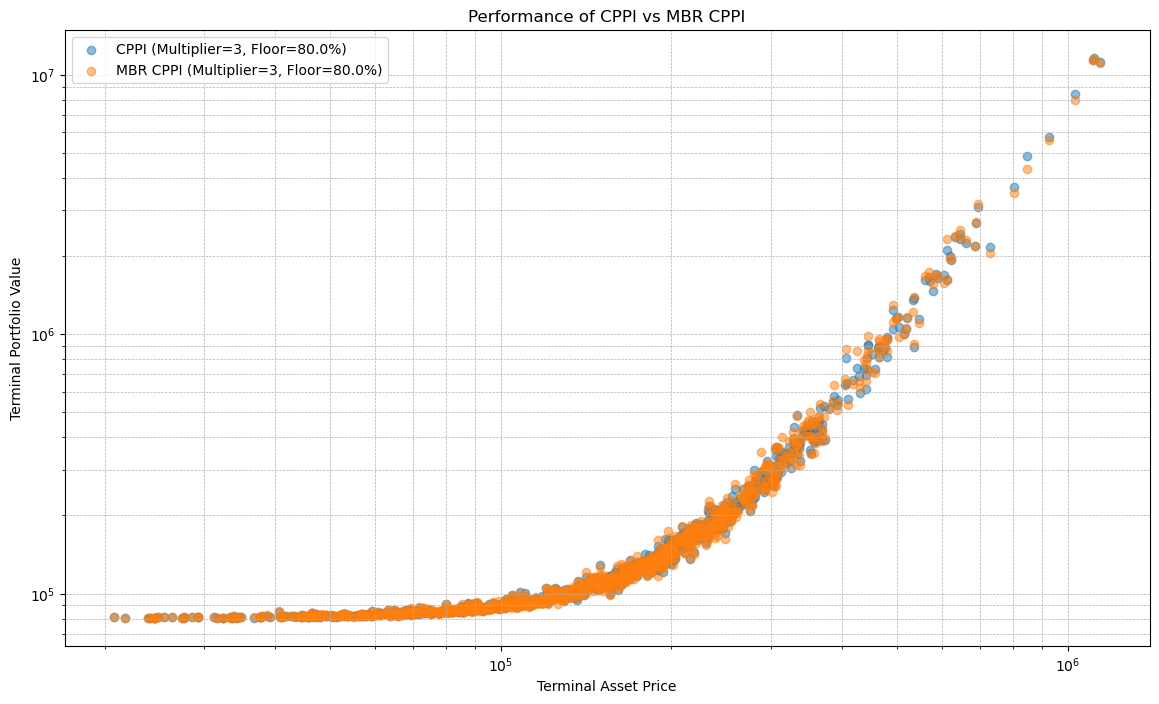

In [143]:
plt.figure(figsize=(14, 8))

# CPPI Outcomes 
plt.scatter(terminal_prices, terminal_cppi, 
            alpha=0.5, 
            label=f'CPPI (Multiplier={multiplier}, Floor={floor_frac*100}%)')

# MBR CPPI Outcomes 
plt.scatter(terminal_prices, terminal_cppi_move_based_rebalancing, 
            alpha=0.5, 
            label=f'MBR CPPI (Multiplier={multiplier}, Floor={floor_frac*100}%)')

plt.title('Performance of CPPI vs MBR CPPI')
plt.xlabel('Terminal Asset Price')
plt.xscale('log')  # Use log scale for better visualization
plt.ylabel('Terminal Portfolio Value')
plt.yscale('log')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [144]:
benchmark_prices = price_paths

# MBR CPPI Strategy Performance
cppi_strategy_results_move_based_rebalancing = cppi_results_move_based_rebalancing[(3, 0.8)]
cppi_portfolio_values_move_based_rebalancing = np.array(cppi_strategy_results_move_based_rebalancing['Basket Values'])
cppi_metrics_move_based_rebalancing = performance(cppi_portfolio_values_move_based_rebalancing, benchmark_prices)
cppi_turnover_move_based_rebalancing = turnover(cppi_strategy_results_move_based_rebalancing['Risky Weights'])

# CPPI Strategy Performance
cppi_strategy_results = cppi_results[(3, 0.8)]
cppi_portfolio_values = np.array(cppi_strategy_results['Basket Values'])
cppi_metrics = performance(cppi_portfolio_values, benchmark_prices)
cppi_turnover = turnover(cppi_strategy_results['Risky Weights'])

# Display Results
def print_metrics(name, metrics, turnover):
    print(f"{name} Strategy Metrics:")
    for metric, value in metrics.items():
        print(f"{metric.replace('_', ' ').title()}: {value:.4f}")
    print(f"Turnover: {turnover:.2f}%\n")

print_metrics("move_based_rebalancing CPPI", cppi_metrics_move_based_rebalancing, cppi_turnover_move_based_rebalancing)
print_metrics("CPPI", cppi_metrics, cppi_turnover)

move_based_rebalancing CPPI Strategy Metrics:
Annualized Return: 1.6063
Annualized Volatility: 0.6421
Sharpe Ratio: 1.1591
Sortino Ratio: 2.2636
Var 5: -0.0530
Es 5: -0.0738
Skewness: -0.0805
Kurtosis: 5.8312
Max Drawdown: -0.4256
Information Ratio: -0.5945
Turnover: 866.81%

CPPI Strategy Metrics:
Annualized Return: 1.6082
Annualized Volatility: 0.6419
Sharpe Ratio: 1.1604
Sortino Ratio: 2.2663
Var 5: -0.0530
Es 5: -0.0737
Skewness: -0.0795
Kurtosis: 5.7962
Max Drawdown: -0.4249
Information Ratio: -0.5981
Turnover: 1447.82%



In [145]:
print('BTC metrics:')
compute_btc_metrics(price_paths)

BTC metrics:


{'Annualized Return': '174.34%',
 'Annualized Volatility': '69.53%',
 'Sharpe Ratio': '2.51',
 'Sortino Ratio': '4.47',
 'VaR (5%)': '-5.62%',
 'Expected Shortfall (5%)': '-6.98%',
 'Skewness': '0.11',
 'Kurtosis': '0.00',
 'Max Drawdown': '-45.60%'}

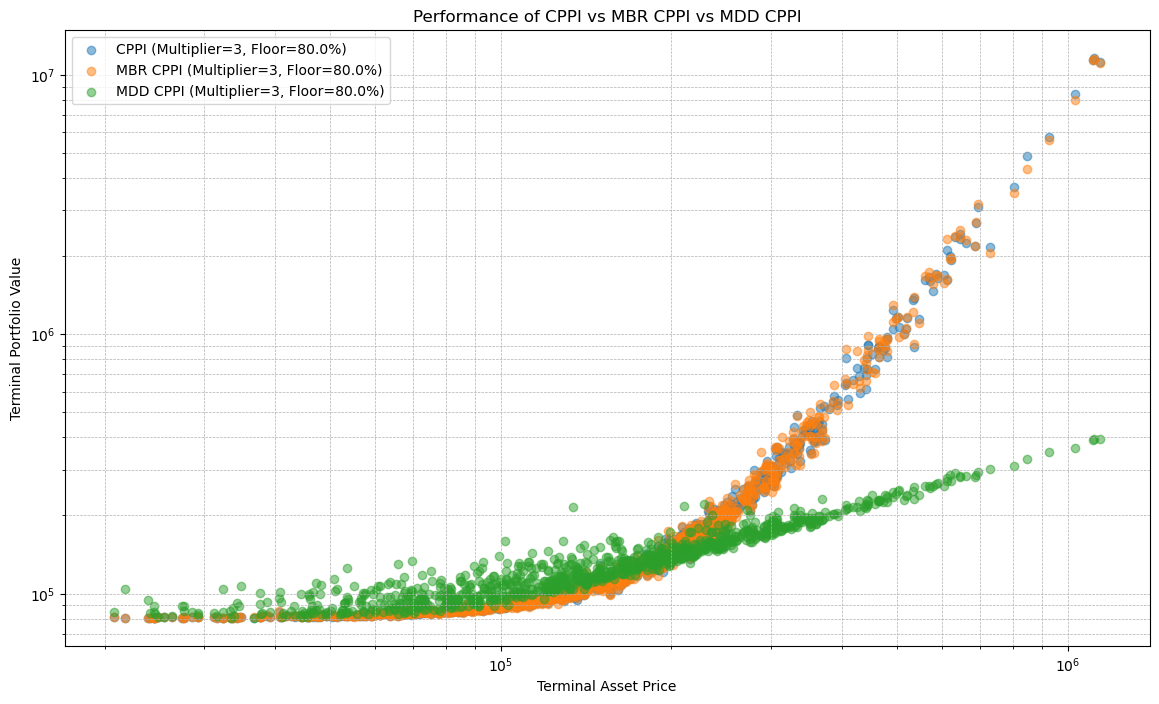

In [146]:
plt.figure(figsize=(14, 8))

# CPPI Outcomes 
plt.scatter(terminal_prices, terminal_cppi, 
            alpha=0.5, 
            label=f'CPPI (Multiplier={multiplier}, Floor={floor_frac*100}%)')

# MBR CPPI Outcomes 
plt.scatter(terminal_prices, terminal_cppi_move_based_rebalancing, 
            alpha=0.5, 
            label=f'MBR CPPI (Multiplier={multiplier}, Floor={floor_frac*100}%)')

# MDD CPPI Outcomes 
plt.scatter(terminal_prices, terminal_cppi_mdd, 
            alpha=0.5, 
            label=f'MDD CPPI (Multiplier={multiplier}, Floor={floor_frac*100}%)')

plt.title('Performance of CPPI vs MBR CPPI vs MDD CPPI')
plt.xlabel('Terminal Asset Price')
plt.xscale('log')  # Use log scale for better visualization
plt.ylabel('Terminal Portfolio Value')
plt.yscale('log')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [147]:
def obpi_strategy_move_based_rebalancing(risky_asset, riskless_rate, floor_fractions, initial_portfolio_value, 
                             time_to_maturity, sigma, delta_threshold):
    """
    Implements the Move-Based OBPI (Option-Based Portfolio Insurance) strategy.
    
    Parameters:
        risky_asset (ndarray): Simulated risky asset prices, shape (n_steps, n_simulations).
        riskless_rate (float): Annualized risk-free rate (e.g., 0.02 for 2%).
        floor_fractions (list): List of floor fractions to test.
        initial_portfolio_value (float): Initial value of the portfolio.
        time_to_maturity (float): Time to maturity in years.
        sigma (float or ndarray): Volatility of the risky asset (annualized).
        delta_threshold (float): Threshold for move-based rebalancing.

    Returns:
        dict: Dictionary containing results for each floor fraction.
    """
    n_steps, n_simulations = risky_asset.shape
    steps_per_year = 365  # Adjust as needed
    riskless_return = (1 + riskless_rate) ** (1 / steps_per_year) - 1
    dt = 1 / steps_per_year  
    results = {}

    def black_scholes_put(S, K, T, r, sigma):
        """ Computes Black-Scholes European put price and delta. """
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        put_delta = -norm.cdf(-d1)
        return put_price, put_delta

    # Ensure sigma is an array of correct shape (n_steps, n_simulations)
    if np.isscalar(sigma):
        sigma = np.full((n_steps, n_simulations), sigma)

    if sigma.shape != (n_steps, n_simulations):
        raise ValueError("sigma must be either a scalar or have shape (n_steps, n_simulations)")

    for floor_fraction in floor_fractions:
        # Initialize arrays
        basket_values = np.zeros((n_steps, n_simulations))
        risky_weights = np.zeros((n_steps, n_simulations))
        riskless_weights = np.zeros((n_steps, n_simulations))
        put_prices = np.zeros((n_steps, n_simulations))
        put_deltas = np.zeros((n_steps, n_simulations))

        # Initial conditions
        floor = initial_portfolio_value * floor_fraction

        # Compute initial put price and delta for all simulations
        initial_put_price, initial_put_delta = black_scholes_put(
            risky_asset[0], floor, time_to_maturity, riskless_rate, sigma[0]
        )

        # Compute initial weights
        risky_w = ((1 + initial_put_delta) * risky_asset[0]) / (risky_asset[0] + initial_put_price)
        risky_w = np.clip(risky_w, 0, 1)  # Ensure weights are between 0 and 1
        riskless_w = 1 - risky_w

        # Set initial values
        basket_values[0, :] = initial_portfolio_value
        risky_weights[0, :] = risky_w
        riskless_weights[0, :] = riskless_w
        put_prices[0, :] = initial_put_price
        put_deltas[0, :] = initial_put_delta
        previous_put_delta = initial_put_delta.copy()  # Track the previous delta

        # Loop over time steps
        for i in range(1, n_steps):
            remaining_ttm = time_to_maturity - i * dt  

            # Compute returns
            risky_return = (risky_asset[i] - risky_asset[i - 1]) / risky_asset[i - 1]

            # Update portfolio value
            portfolio_return = (risky_weights[i - 1] * risky_return +
                                riskless_weights[i - 1] * riskless_return)
            basket_values[i] = basket_values[i - 1] * (1 + portfolio_return)

            # Compute new put option price and delta
            put_price, put_delta = black_scholes_put(
                risky_asset[i], floor, remaining_ttm, riskless_rate, sigma[i]
            )

            # Compute the absolute change in put delta
            delta_change = np.abs(put_delta - previous_put_delta)

            # Boolean mask: True where the change exceeds the threshold
            rebalance_mask = delta_change > delta_threshold

            # Rebalance only where needed
            risky_w[rebalance_mask] = ((1 + put_delta[rebalance_mask]) * risky_asset[i, rebalance_mask]) / (
                risky_asset[i, rebalance_mask] + put_price[rebalance_mask]
            )
            risky_w = np.clip(risky_w, 0, 1)  # Ensure weights remain valid
            riskless_w = 1 - risky_w

            # Update previous put delta only for rebalanced elements
            previous_put_delta[rebalance_mask] = put_delta[rebalance_mask]

            # Store values
            risky_weights[i] = risky_w
            riskless_weights[i] = riskless_w
            put_prices[i] = put_price
            put_deltas[i] = put_delta

        # Store results
        results[floor_fraction] = {
            "Basket Values": basket_values,
            "Risky Weights": risky_weights,
            "Riskless Weights": riskless_weights,
            "Put Price": put_prices,
            "Put Delta": put_deltas,
        }

    return results

In [157]:
time_to_maturity = len(price_paths)/365  # adjust (52 for weekly, 365 for daily)
delta_threshold = 0.4

obpi_results_move_based_rebalancing = obpi_strategy_move_based_rebalancing(price_paths, 0.04, floor_fractions, initial_portfolio_value, time_to_maturity, historical_volatility.iloc[0], delta_threshold)

In [158]:
floor_frac = 1
key = (floor_frac)

terminal_prices = price_paths[-1]  # Last row of price simulations
terminal_obpi = obpi_results[key]['Basket Values'][-1]  # Last row of OBPI basket values
terminal_obpi_move_based_rebalancing = obpi_results_move_based_rebalancing[key]['Basket Values'][-1]  # Last row of leveraged OBPI basket values

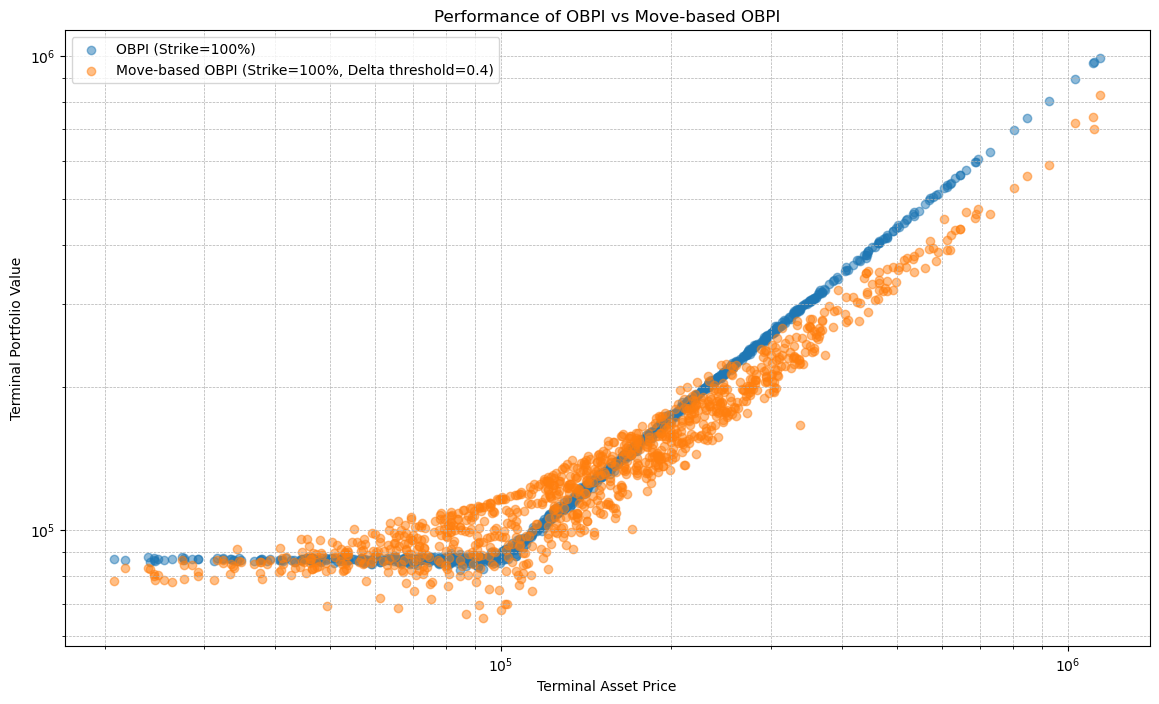

In [159]:
plt.figure(figsize=(14, 8))

# OBPI Outcomes 
plt.scatter(terminal_prices, terminal_obpi, 
            alpha=0.5, 
            label=f'OBPI (Strike={floor_frac*100}%)')

# Move-based OBPI Outcomes 
plt.scatter(terminal_prices, terminal_obpi_move_based_rebalancing, 
            alpha=0.5, 
            label=f'Move-based OBPI (Strike={floor_frac*100}%, Delta threshold={delta_threshold})')

plt.title('Performance of OBPI vs Move-based OBPI')
plt.xlabel('Terminal Asset Price')
plt.xscale('log')  # Use log scale for better visualization
plt.ylabel('Terminal Portfolio Value')
plt.yscale('log')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()